In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import urllib
import gzip
import shutil
from io import StringIO
import jdutil
from sklearn.metrics.pairwise import haversine_distances
import os
import astropy
import astropy.time
import requests
from bs4 import BeautifulSoup
import re
import math
from numba import njit
import matplotlib.animation as animation
import datetime
import networkx as nx
import scipy.stats as stats

In [2]:
class OkadaSurface(nn.Module):
    def __init__(self, initial_force_magnitude=1, initial_depth=1):
        super().__init__()
        location_init = torch.zeros(3)
        location_init[2] = initial_depth
        self.location_p = torch.nn.Parameter(location_init)
        self.location_p.requires_grad = True
        self.force_p = torch.nn.Parameter(torch.ones(3)*initial_force_magnitude/3)
        self.force_p.requires_grad = True
        self.factor_p = torch.nn.Parameter(torch.ones(1)*0.25)
        self.factor_p.requires_grad = True
    # input is (*,2) or (*, 3)
    def forward(self, x):
        r = x - self.location_p[None,:]
        r_norm = torch.norm(r, dim=1)
        ri_rj = torch.einsum('bi,bj->bij', (x,x))
        u = 1/r_norm[:,None,None] + ri_rj/r_norm[:,None,None]**3
        internal_u = torch.zeros(( x.size(0) ,3, 3))
        internal_u[:, 0,0] = 1/(r_norm+r[:,2])
        internal_u[:, 1,1] = 1/(r_norm+r[:,2])
        internal_u[:, 2,2] = 1/(r_norm+r[:,2])
        temp0 = (r_norm*(r_norm+r[:,2]))
        temp1 = temp0/r_norm+r[:,2]
        internal_u[:, :, 2] += r/temp0[:,None]
        internal_u[:, 2, :2] -=  r[:,:2]/temp0[:,None]
        internal_u[:,:2,:2] -= ri_rj[:,:2,:2]/temp1[:,None,None]
        u += self.factor_p*internal_u
        return u@self.force_p

In [3]:
@njit
def okada92_B(x, xi, alpha, mu, F):
    # x must be of shape (*, 3)
    # xi has shape (3,)
    u = np.zeros((x.shape[0], 3, 3)) # u_i^j
    R_vec = np.zeros(3)
    for k in range(0, x.shape[0]):
        R_vec[0] = x[k,0] - xi[0]
        R_vec[1] = x[k,1] - xi[1]
        R_vec[2] = x[k,2] - xi[2]
        R = np.sqrt(R_vec[0]**2+R_vec[1]**2+R_vec[2]**2)
        for i in range(3):
            u[k,i,i] += 1/R
            for j in range(3):
                u[k,i,j] += R_vec[i]*R_vec[j]/(R**3)
                ub_last = 0
                if(i != 2 and j != 2):
                    ub_last += -(R_vec[i]*R_vec[j]/R)/((R+R_vec[2])**2)
                if(i==j):
                    ub_last += 1/(R+R_vec[2])
                if(j==2):
                    ub_last += R_vec[i]/(R*(R+R_vec[2]))
                if(i == 2 and j != 2):
                    ub_last += -R_vec[j]/(R*(R+R_vec[2]))
                ub_last *= (1-alpha)/alpha
                u[k,i,j] += ub_last
                u[k,i,j] *= F/(4*np.pi*mu)
    return u    

In [411]:
edge_list, edge_weights = baiesi_clustering(reference_catalog.lat.values, reference_catalog.lon.values, reference_catalog.mag.values,
                            (reference_catalog.date-reference_catalog.loc[0,'date']).values.astype('timedelta64[s]').astype('float'),
                            b=1.00,
                            d_f=1.6,
                            p=1.0)

In [421]:
baiesi_df = pd.DataFrame()
baiesi_df['source'] = edge_list[:,0]
baiesi_df['target'] = edge_list[:,1]
baiesi_df['weight'] = edge_weights

In [422]:
n_threshold = 1e3
graph = nx.from_pandas_edgelist(baiesi_df, edge_attr='weight',create_using=nx.DiGraph)
long_edges = list(filter(lambda e: e[2] < n_threshold, (e for e in graph.edges.data('weight'))))
le_ids = list(e[:2] for e in long_edges)
# remove filtered edges from graph G
graph.remove_edges_from(le_ids)
comps = list(nx.weakly_connected_components(graph))

KeyboardInterrupt: 

In [ ]:
for comp in comps:
    if(len(comp) > 10):
        plt.scatter(reference_catalog.date.values[list(comp)], reference_catalog.mag.values[list(comp)])
        plt.show()

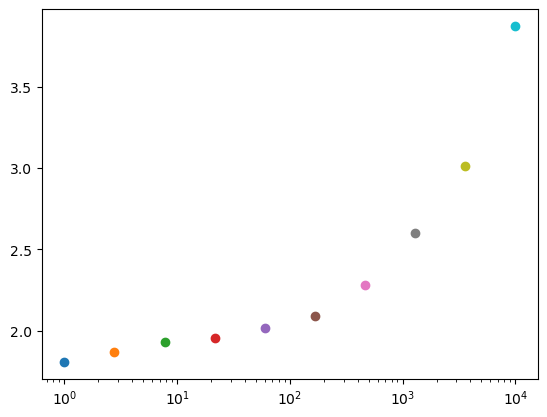

In [385]:
for n_threshold in np.logspace(0, 4, 10):
    graph = nx.from_pandas_edgelist(baiesi_df, edge_attr='weight',create_using=nx.DiGraph)
    long_edges = list(filter(lambda e: e[2] < n_threshold, (e for e in graph.edges.data('weight'))))
    le_ids = list(e[:2] for e in long_edges)
    # remove filtered edges from graph G
    graph.remove_edges_from(le_ids)
    comps = nx.weakly_connected_components(graph)
    lengths = np.array([len(comp) for comp in comps])
    comps = list(nx.weakly_connected_components(graph))
    #plt.scatter(reference_catalog.date.values[list(comps[0])], reference_catalog.mag.values[list(comps[0])])
    #plt.show()
    hist, edges = np.histogram(lengths, bins=np.logspace(0,4, 30), density=True)
    mask = hist>0
    res = stats.linregress(np.log(edges[:-1][mask]), np.log(hist[mask]))
    plt.scatter(n_threshold, -res[0])
plt.xscale('log')

In [4]:
@njit(nogil=True)
def haversine_single_deg(lat1, lon1, lat2, lon2):
    d_lat_rad = np.pi*(lat1-lat2)/180
    d_lon_rad = np.pi*(lon1-lon2)/180
    a = np.sin(d_lat_rad/2)**2 + np.cos(np.pi*lat1/180)*np.cos(np.pi*lat2/180)*((np.sin(d_lon_rad/2))**2)
    return 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
from numba.typed import List as nbList


@njit(nogil=True)
def baiesi_clustering(lats, lons, mags, times, b, d_f, p):
    n_events = len(lats)
    n_pairs = (n_events*(n_events-1))//2
    edge_list = np.zeros((n_pairs,2), dtype=np.int64)
    edge_weights =  np.zeros(n_pairs)
    edge_index = 0
    for i in range(0, n_events):
        for j in range(i-1, -1, -1): # we look for all the earthquake occurring prior to 'i'
            dt_ij = times[i]-times[j] # is positive, as j occur before i
            r_ij = 6371*haversine_single_deg(lats[i], lons[i], lats[j], lons[j])
            n_ij = ((dt_ij**p)*(r_ij**d_f))*10**(-b*mags[j])
            edge_list[edge_index,0] = j
            edge_list[edge_index,1] = i
            edge_weights[edge_index] = n_ij
            edge_index += 1
    return edge_list, edge_weights


@njit(nogil=True)
def baiesi_clustering_old(lats, lons, mags, times, b, d_f, p):
    n_events = len(lats)
    event_parent = np.zeros(n_events, dtype=np.int64)
    n_best = np.zeros(n_events)
    for i in range(0, n_events):
        min_n = np.infty
        min_at = i
        for j in range(i-1, -1, -1): # we look for all the earthquake occurring prior to 'i'
            dt_ij = times[i]-times[j] # is positive, as j occur before i
            r_ij = 6371*haversine_single_deg(lats[i], lons[i], lats[j], lons[j])
            n_ij = ((dt_ij**p)*(r_ij**d_f))*10**(-b*mags[j])
            if(n_ij < min_n):
                min_at = j
                min_n = n_ij
        if(min_at == i): # a single even with no parent
            min_n = 0
        event_parent[i] = min_at
        n_best[i] = min_n
    return event_parent, n_best

In [5]:
@njit(nogil=True)
def pbc_dist(a,b,p):
    d = abs(a-b)
    return min(p-d, d)

@njit(nogil=True)
def haversine_1d(pos_rads, origin_rads):
    '''
    pos_rads: will be N stations, with 2 coordinates
    origin_rads: will be only one point
    To compute a distance between two points / sets of points
    '''
    a = np.sin((origin_rads[0]-pos_rads[:,0])/2)**2 + np.cos(origin_rads[0])*np.cos(pos_rads[:,0])*((np.sin((origin_rads[1]-pos_rads[:,1])/2))**2)
    return 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))

def fit_constrained(stations_positions_rads, data,n_rows, n_cols, latr_origin, lonr_origin, spacing_rads,sigma_rads, reg_factor = 3, nu=0.5, index_ratio = 0.6):
    '''
    This interpolation assumes the top crust to be modelled as a 2D thin elastic sheet
    Then one interplate displacements based on that model.
    Reference to the original paper:
    https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016GL070340
    '''

    cutoff = spacing_rads*reg_factor
    N = stations_positions_rads.shape[0]
    bf_matr = np.zeros((2*N, 2*N))
    for i,i_pos in enumerate(stations_positions_rads):
        d_ij = haversine_1d(stations_positions_rads, i_pos) + cutoff
        for j,j_pos in enumerate(stations_positions_rads):
            #q_ij = (3-nu)*np.log(d_ij[j]) + (1+nu)*((i_pos[1]-j_pos[1])**2)/d_ij[j]**2
            #p_ij = (3-nu)*np.log(d_ij[j]) + (1+nu)*((i_pos[0]-j_pos[0])**2)/d_ij[j]**2
            #w_ij =  (-(1+nu))*(i_pos[0]-j_pos[0])*(i_pos[1]-j_pos[1])/d_ij[j]**2
            dlon_ij, dlat_ij = i_pos[1]-j_pos[1], i_pos[0]-j_pos[0]
            q_ij = (3-nu)*np.log(d_ij[j]) + (1+nu)*((dlon_ij)**2)/d_ij[j]**2
            p_ij = (3-nu)*np.log(d_ij[j]) + (1+nu)*((dlat_ij)**2)/d_ij[j]**2
            w_ij =  (-(1+nu))*(dlon_ij*dlat_ij)/d_ij[j]**2
            bf_matr[2*i, 2*j] = q_ij
            bf_matr[2*i, 2*j+1] = w_ij
            bf_matr[2*i+1, 2*j] = w_ij
            bf_matr[2*i+1, 2*j+1] = p_ij
    uu, vv, vvh = np.linalg.svd(bf_matr)
    index_cut = int(index_ratio*bf_matr.shape[0])
    known_vec = np.stack([data[:,0],data[:,1]]).T.flatten()
    #body_forces = np.linalg.inv(bf_matr)@known_vec
    body_forces = ((vvh.conj().T)[:, :index_cut]@np.diag(1/vv[:index_cut])@(uu.conj().T)[:index_cut,:])@known_vec
    v = np.zeros((n_rows, n_cols, 3)) 
    for i in range(n_rows):
        grid_latr = latr_origin + i*spacing_rads
        for j in range(n_cols):
            grid_lonr = lonr_origin + j*spacing_rads
            grid_pos_rads = np.array([grid_latr,grid_lonr ])
            d = haversine_1d(stations_positions_rads,grid_pos_rads) + cutoff
            closes_station_idx = np.argmin(d)
            v[i,j,2] = np.exp(-0.5*((d[closes_station_idx]-cutoff)/sigma_rads)**2)
            dlonr, dlatr = grid_lonr-stations_positions_rads[:,1], grid_latr-stations_positions_rads[:,0]
            #q_s = (3-nu)*np.log(d) + (1+nu)*((grid_lonr-stations_positions_rads[:,1])**2)/d**2
            #p_s = (3-nu)*np.log(d) + (1+nu)*((grid_latr-stations_positions_rads[:,0])**2)/d**2
            #w_s =  (-(1+nu))*(grid_latr-stations_positions_rads[:,0])*(grid_lonr-stations_positions_rads[:,1])/d**2
            q_s = (3-nu)*np.log(d) + (1+nu)*((dlonr)**2)/d**2
            p_s = (3-nu)*np.log(d) + (1+nu)*((dlatr)**2)/d**2
            w_s =  (-(1+nu))*(dlatr*dlonr/d**2)
            v[i,j,0] = np.sum(q_s*body_forces[::2]+ w_s*body_forces[1::2])
            v[i,j,1] = np.sum(w_s*body_forces[::2]+ p_s*body_forces[1::2])
    return v, body_forces

In [6]:
def load_isc_catalog(file_name, is_header_commented=False, extract_minimal_features=True):
    default_header = ["date","lat","lon","smajax","sminax","strike","q","depth","unc","q","mw","unc","q","s","mo","fac","mo_auth","mpp","mpr","mrr","mrt","mtp","mtt","str1","dip1","rake1","str2","dip2","rake2","type","eventid"]
    if(not is_header_commented):
        catalog  = pd.read_csv(file_name, comment='#', sep=",", low_memory=False, parse_dates=['date'])
    else:
        catalog  = pd.read_csv(file_name, comment='#', sep=",", low_memory=False)
    catalog.columns = default_header
    if(extract_minimal_features):
        catalog = catalog[['date', 'lat', 'lon', 'mw']]
        catalog.rename(columns={'mw' : 'mag'}, inplace=True)
    return catalog

In [7]:
def download_isc_rect(lat_window, lon_window, start_date, end_date, min_mag):
    isc_url = f'http://www.isc.ac.uk/cgi-bin/web-db-run?request=COMPREHENSIVE&out_format=CATCSV&searchshape=RECT&bot_lat={lat_window[0]}&top_lat={lat_window[1]}&left_lon={lon_window[0]}&right_lon={lon_window[1]}&ctr_lat=&ctr_lon=&radius=&max_dist_units=deg&srn=&grn=&start_year={start_date[0]}&start_month={start_date[1]}&start_day={start_date[2]}&start_time=00%3A00%3A00&end_year={end_date[0]}&end_month={end_date[1]}&end_day={end_date[2]}&end_time=00%3A00%3A00&min_dep=&max_dep=&min_mag={min_mag}&max_mag=&req_mag_type=&req_mag_agcy='
    resp = requests.get(isc_url)
    soup = BeautifulSoup(resp.text)
    for tag in soup.find_all('pre'):
        content = tag.contents[0].strip()
        if('EVENTID' in content):
            startIdx = content.find('EVENTID')
            stopIdx = content.find('STOP')
            content =content[startIdx:stopIdx].strip()
            lines = []
            for line in content.split('\n'):
                fixed_line = ",".join([s.strip(',') for s in line.split(",")[:12]])
                lines.append(fixed_line + "\n") 
            content = "".join(lines)
            content = re.sub("(?<=([0-9]|[a-z]|[A-Z]))\s+(?=,)", "", content)
            csvStringIO = StringIO(content)
            df = pd.read_csv(csvStringIO, sep=",")
            df.rename({ col_name : col_name.strip() for col_name in df.columns}, inplace=True, axis=1)
            df = df[['EVENTID','DATE','TIME','LAT','LON','DEPTH','MAG']]
            df.rename({'EVENTID':'eventid','DATE':'day','TIME':"time",'LAT':'lat','LON':'lon','DEPTH':'depth','MAG':'mag'}, inplace=True, axis=1)
            df['date'] = pd.to_datetime(df.day) + pd.to_timedelta(df.time)
            return df

In [8]:
# this is from reference 1980's GPS time
J2000_gps_weeks = 1042
J2000_gps_residual_seconds = 561548.816
J2000_gps_seconds = 604800*J2000_gps_weeks + 561548.816    

def gps2utc(gpsweek, gpsseconds):
    """ GPS time to UTC.

    Parameters
    ----------
    gpsweek : int
        GPS week number, i.e. 1866.
    gpsseconds : int
        Number of seconds since the beginning of week.

    Returns
    -------
    datetime
        datetime instance with UTC time.
    """
    secs_in_week = 604800
    secs = gpsweek * secs_in_week + gpsseconds

    t_gps = astropy.time.Time(secs, format="gps")
    t_utc = astropy.time.Time(t_gps, format="iso", scale="utc")
    return t_utc.datetime

def J2000_to_utc(secs):
    t_gps = astropy.time.Time(secs+J2000_gps_seconds, format="gps")
    t_utc = astropy.time.Time(t_gps, format="iso", scale="utc")
    return t_utc.datetime
    
class NGLDownloader:
    ngl_full_list = "http://geodesy.unr.edu/NGLStationPages/llh.out"
    ngl_24h_2w = "http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt"
    ngl_24h_24h = "http://geodesy.unr.edu/NGLStationPages/DataHoldingsRapid24hr.txt"
    ngl_5min_24h = "http://geodesy.unr.edu/NGLStationPages/DataHoldingsRapid5min.txt"
    ngl_5min_1h30min = "http://geodesy.unr.edu/NGLStationPages/DataHoldingsUltra5min.txt"
    
    
    east_ref_name = "___e-ref(m)"
    north_ref_name = "___n-ref(m)"
    vertical_ref_name = "___v-ref(m)"
    
    
    @staticmethod
    def process_station_list(url):
        station_list = pd.read_csv(url, sep=r"\s+", on_bad_lines='skip', parse_dates=['Dtbeg', 'Dtend'])
        station_list.rename(columns={'Sta' : 'name', 'Lat(deg)' : 'lat', 'Long(deg)' : 'lon', 'Hgt(m)' : 'height', 'X(m)' : 'x', 'Y(m)' : 'y', 'Z(m)' : 'z', 'Dtbeg' : 'begin', 'Dtend' : 'end'   }, inplace=True)
        station_list['lon'] =  (station_list['lon'] + 180)%360-180 # ensures values in [-180, 180]
        return station_list
    
    @staticmethod
    def retrieve_year_5min_rapid(station,year):
        url = "http://geodesy.unr.edu/gps_timeseries/kenv/%s/%s.%4i.kenv.zip"
        try:
            filehandle, _ = urllib.request.urlretrieve(url % (station, station, year))
        except:
            return None
        zip_file_object = zipfile.ZipFile(filehandle, 'r')
        dataframes = {}
        for nl in zip_file_object.namelist():
            file = zip_file_object.open(nl)
            with gzip.open(file, 'rb') as f:
                content = f.read().decode('ascii')
                content_df = pd.read_csv(StringIO(content), sep="\s+")
                doy = content_df['doy'].values[0]
                dataframes[doy] = content_df            
        return dataframes
    
    

    @staticmethod
    def merge_year_5min_rapid(dataframes_dict):
        max_day = 365
        if(366 in dataframes_dict.keys()):
            max_day += 1
        rows = []
        for day in range(1, 1+max_day):
            if(day in dataframes_dict):
                north = dataframes_dict[day][NGLDownloader.north_ref_name]
                east = dataframes_dict[day][NGLDownloader.east_ref_name]
                vertical = dataframes_dict[day][NGLDownloader.vertical_ref_name]    
                seconds_day = dataframes_dict[day]['s-day']
                seconds_J2000 = dataframes_dict[day]['sec-J2000']
                row = np.array((seconds_J2000,north, east, vertical)).T
                rows.append(row)
        rows = np.concatenate(rows)
        return rows
    
    @staticmethod
    def str_to_datetime(s, limit_for_2000):
        str_to_month = {'JAN':1, 'FEB':2, 'MAR':3, 'APR' : 4, 'MAY':5, 'JUN':6, 'JUL' : 7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12}
        d = int(s[5:])
        m = str_to_month[s[2:5]]
        y = s[:2]
        if(int(y) > limit_for_2000):
            y = int("19" + y)
        else:
            y = int("20" + y)
        return datetime.datetime(y, m, d)   ## change this to datetime.datetime ?
     
    #valid options are:
    # interval_type = 5, 24
    # quality_type = 0, 1
    def __init__(self, output_folder, interval_type, quality_type=1):
        self.rootpath = output_folder
        self.interval_type = interval_type
        self.quality_type = quality_type
        if(interval_type==5):
            if(quality_type==0):
                self.station_list = NGLDownloader.process_station_list(NGLDownloader.ngl_5min_1h30min)
            else:
                self.station_list = NGLDownloader.process_station_list(NGLDownloader.ngl_5min_24h)
        else:
            if(quality_type==0):
                self.station_list = NGLDownloader.process_station_list(NGLDownloader.ngl_24h_24h)
            else:
                self.station_list = NGLDownloader.process_station_list(NGLDownloader.ngl_24h_2w)       
    
    
    def get_all_stations_within_radius(self, lat_origin, lon_origin, maximal_radius, r0=6371):
        dists = haversine_distances(np.radians(self.station_list[['lat','lon']].values), np.radians(np.array([lat_origin, lon_origin]))[None,:])[:,0]
        return self.station_list.name.values[dists <= maximal_radius/r0].astype('str')
    
    
    def download_data_year_loc_5min_rapid(self, year, lat_origin, lon_origin, maximal_radius, verbose=False,r0=6371):
        stations_to_load = self.get_all_stations_within_radius(lat_origin, lon_origin, maximal_radius)
        num_downloaded = 0
        num_existing = 0
        num_failed = 0
        for counter,stat_name in enumerate(stations_to_load):
            if(verbose):
                print(stat_name, counter*100/len(stations_to_load))
            filename = self.rootpath + stat_name + "_" + str(year) + ".npz"
            if(os.path.exists(filename)):
                num_existing += 1
                continue
            dfs = NGLDownloader.retrieve_year_5min_rapid(stat_name, year)
            if(dfs is None):
                num_failed += 1
                continue
            num_downloaded += 1
            tseries = NGLDownloader.merge_year_5min_rapid(dfs)
        
            np.savez(filename,seconds=tseries[:,0],north=tseries[:,1],
                     east=tseries[:,2], vertical=tseries[:,3])
        return stations_to_load, num_downloaded, num_existing, num_failed
            
    def postprocess_year_5min_rapid(self, names, year):
        dataframes = {}
        for stat_name in names:
            filename = self.rootpath + stat_name + "_" + str(year) + ".npz"
            if(os.path.exists(filename)):
                data = np.load(filename)
                origin_datetime = np.datetime64(J2000_to_utc(data['seconds'][0]))
                delta_times = (data['seconds'] - data['seconds'][0]).astype('timedelta64[s]')
                correct_datetimes = origin_datetime + delta_times
                df = pd.DataFrame()
                df['datetime'] = correct_datetimes
                df['north'] = data['north']
                df['east'] = data['east']
                df['vertical'] = data['vertical']
                dataframes[stat_name] = df
        return dataframes
    
    def retrieve_station_24h_final(self, station_name, data_type="tenv3"):
        filename = self.rootpath + station_name + ".csv"
        if(os.path.exists(filename)):
            return pd.read_csv(self.rootpath + station_name + ".csv", sep =" ", parse_dates=['date']), "loaded"
        labels_to_rename = {"_latitude(deg)" : "lat" ,"_longitude(deg)" : "lon", "__height(m)": "height"}
        base_url = "http://geodesy.unr.edu/gps_timeseries/" + data_type
        data =  pd.read_csv(base_url + "/IGS14/" + station_name + "." + data_type, sep=r"\s+")
        #data = pd.read_csv(self.rootpath + name + ".csv")
        data['date'] = [ NGLDownloader.str_to_datetime(s, 23) for s in data['YYMMMDD']]
        data['date'] = data['date'].values.astype('datetime64[D]')
        data.rename(labels_to_rename,axis=1, inplace=True)
        data = data[['date','site','lat','lon','height']]
        #data['lon'] = data['lon'] % 180
        data.to_csv(filename, sep=" ", index=False)
        return data, "downloaded"

In [13]:
lat_window = [35,47]
lon_window = [140, 155]
start_date = (2000,1,1)
end_date = (2022,12,31)
min_mag = 4
isc_full_cat = download_isc_rect(lat_window, lon_window, start_date, end_date, min_mag)
isc_full_cat.to_csv('isc_full_cat.csv', index=False)

In [14]:
rootpath="/Users/vincenzo/gps_5min_csv/"
rootpath24="/Users/vincenzo/gps_24h_csv/"
#rootpath="D:/Vicio/gps_5min_csv/"
ngld24 = NGLDownloader(rootpath24, interval_type=24)
ngld = NGLDownloader(rootpath, interval_type=5)

In [15]:
center = np.mean(lat_window), np.mean(lon_window)
origin = lat_window[0], lon_window[0]
large_plot_stats = ngld24.get_all_stations_within_radius(*center, 1700)
r0 = 6371
cell_size_rads = 5/r0
cell_size_degs = 180*cell_size_rads/np.pi

In [16]:
use_custom = False
if(not use_custom):
    small_cat = False
    if(small_cat):
        reference_catalog = load_isc_catalog('isc-gem-cat.csv')
    else:
        reference_catalog = isc_full_cat
        reference_catalog['day'] = pd.to_datetime(reference_catalog['day']).values.astype('datetime64[D]')

        
    large_quakes = reference_catalog[(reference_catalog.mag >= 6.5)*(reference_catalog.date >= datetime.datetime(2000,1,1))].copy()
    large_quakes.reset_index(inplace=True, drop=True)
    large_quakes['qid'] = np.arange(0, len(large_quakes))
else:
    fit_catalog = pd.read_csv('custom_catalog.csv', sep=" ", parse_dates=['datetime'])
    fit_catalog['day'] = fit_catalog.datetime.values.astype('datetime64[D]')
    fit_catalog.sort_values(by='day', inplace=True)
    fit_catalog.reset_index(drop=True, inplace=True)
    fit_catalog.rename({'seq_id':'qid', 'day':'date'}, axis=1, inplace=True)
    large_quakes = fit_catalog[fit_catalog.type==1].copy()

In [17]:
stats_quakes = {}
stats_data = {}
for cnt, (_,row) in enumerate(large_quakes.iterrows()):
    lat_origin = row.lat
    lon_origin = row.lon
    print(lat_origin, lon_origin)
    names = ngld24.get_all_stations_within_radius(lat_origin, lon_origin, 500) #max(10**(mag/2 - 0.79), 200))
    print('Candidates num.:', len(names))
    found_stats = 0
    for name in names:
        if(name not in stats_data):  
            data, status = ngld24.retrieve_station_24h_final(name)
            data['lon'] = (data['lon'] +180)%360-180 # ensures valus in [-180, 180]
            stats_data[name] = data
            #print(name, status)
    stats_quakes[row.qid] = (row.date, lat_origin, lon_origin, row.mag, row.qid,names)

43.0807 146.7635
Candidates num.: 167
38.8792 141.452
Candidates num.: 612
41.9179 143.9202
Candidates num.: 353
41.8776 144.1739
Candidates num.: 351
42.8941 145.2101
Candidates num.: 257
38.2167 142.0212
Candidates num.: 590
38.1179 144.8999
Candidates num.: 274
46.5738 153.354
Candidates num.: 0
46.1283 154.4197
Candidates num.: 0
37.4882 138.5357
Candidates num.: 838
39.7815 141.5357
Candidates num.: 544
38.2963 142.498
Candidates num.: 538
37.31 142.24
Candidates num.: 608
36.2274 141.088
Candidates num.: 693
36.0692 142.1388
Candidates num.: 620
38.051 144.6297
Candidates num.: 302
36.1862 141.6639
Candidates num.: 656
39.2219 142.5316
Candidates num.: 511
38.2513 141.7296
Candidates num.: 611
38.0553 143.3016
Candidates num.: 442
40.842 145.0154
Candidates num.: 350
37.8759 144.1609
Candidates num.: 359
37.8201 144.1594
Candidates num.: 360
46.0722 150.924
Candidates num.: 0
37.1457 144.754
Candidates num.: 281
44.6329 148.7298
Candidates num.: 78
42.0438 142.6972
Candidates num

1
2003-05-26 09:24:33.840000
38.8792 141.452
33.49383937226069
[0.00039061 0.00350723]


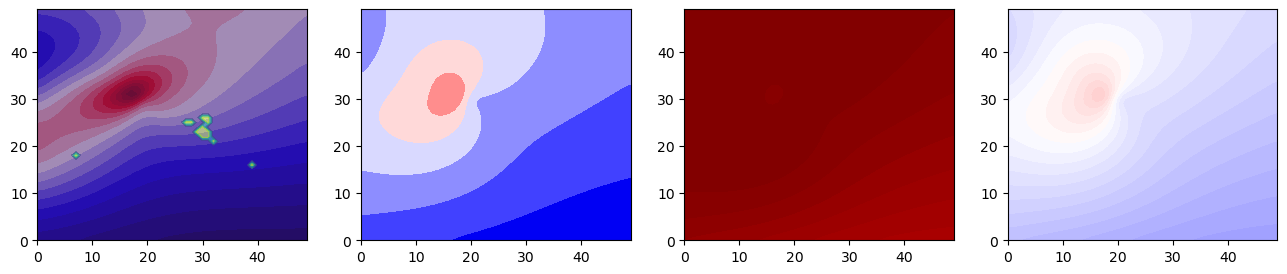

[0.00364185 0.00655768]


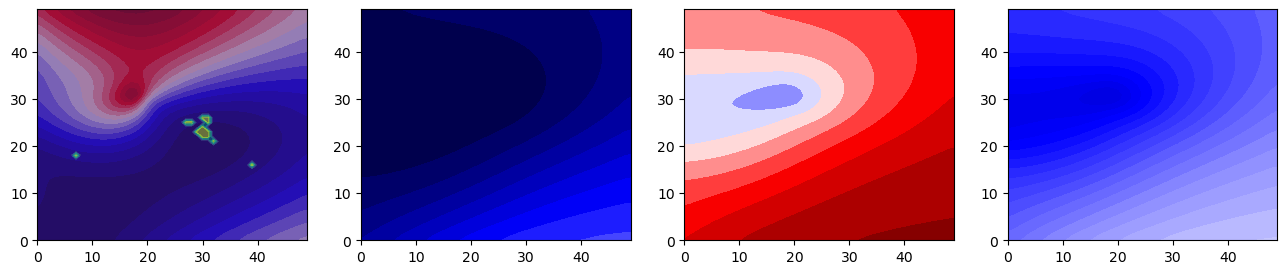

[0.00173554 0.01455557]


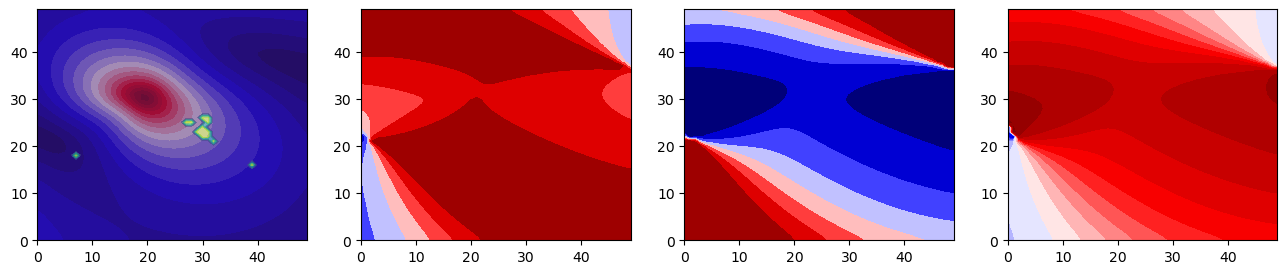

1 ........
2
2003-09-25 19:50:08.090000
41.9179 143.9202
123.29618600746127
[0.00073498 0.00545216]


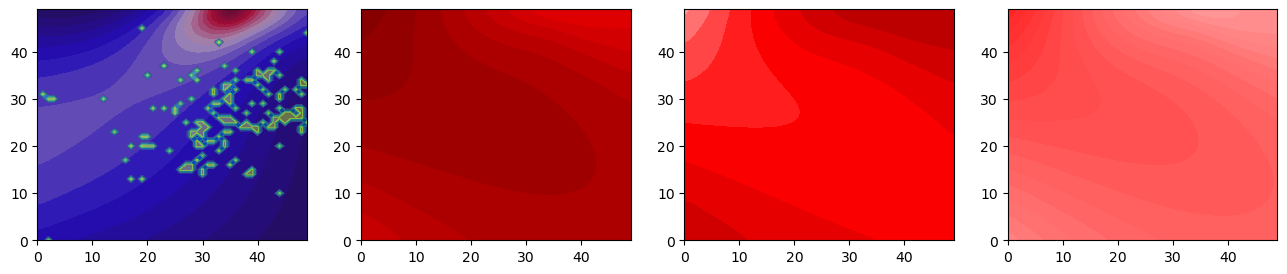

[0.00116431 0.00354515]


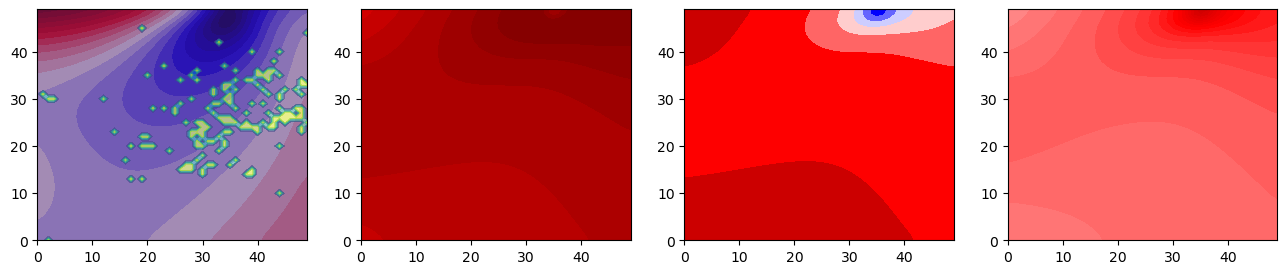

[0.00293424 0.0097135 ]


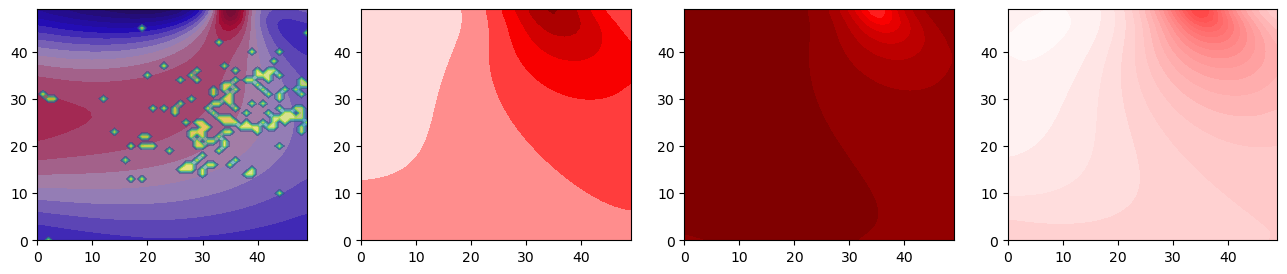

2 ........
3
2003-09-26 18:12:14.780000
41.8776 144.1739
123.15993614786225
[0.00116431 0.00354515]


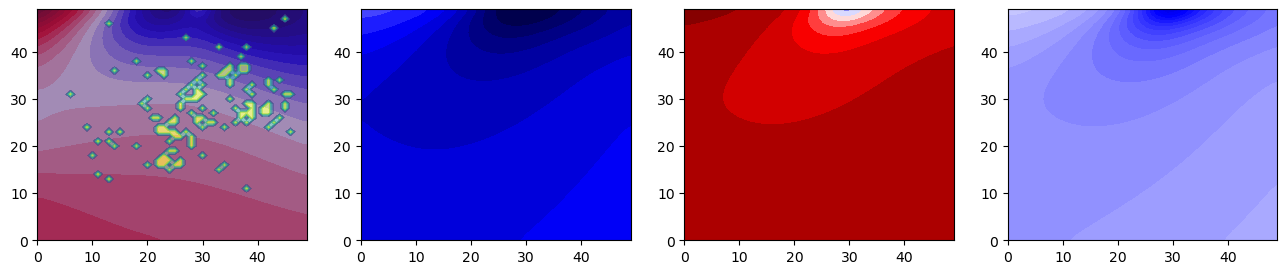

[0.00293424 0.0097135 ]


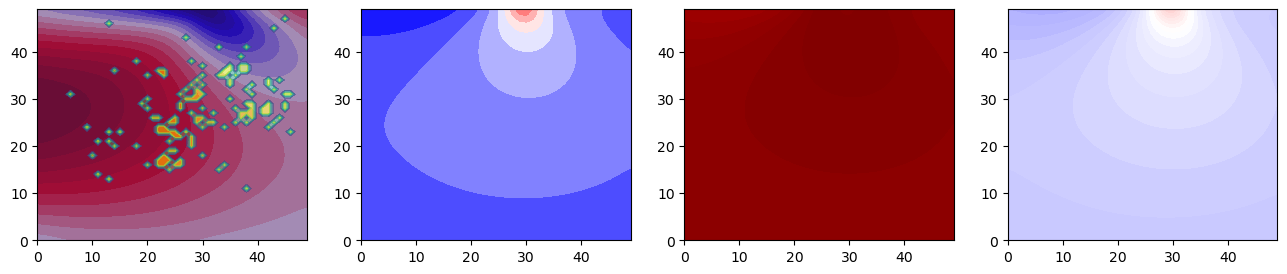

[0.00073633 0.24392297]


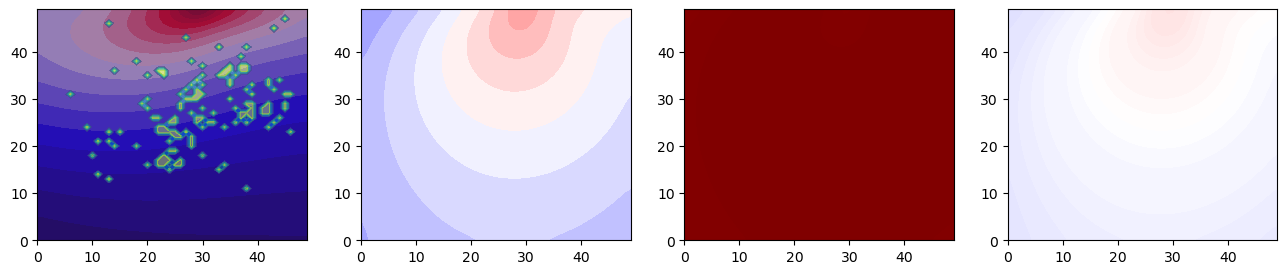

3 ........
5
2005-08-16 02:46:28.490000
38.2167 142.0212
92.28227332873932
[0.00051258 0.00613629]


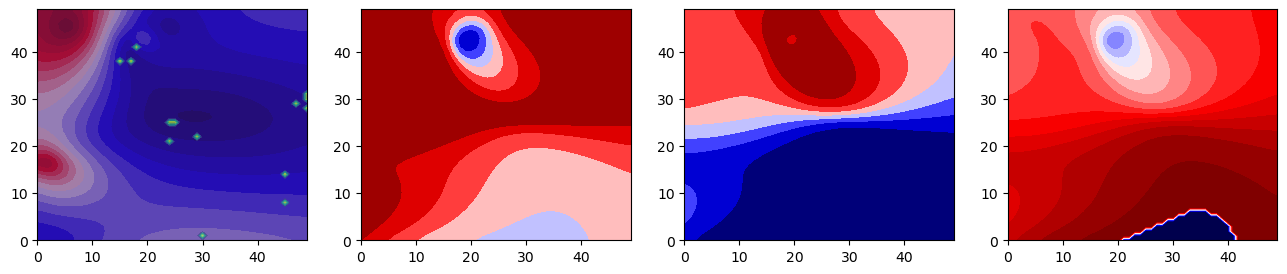

[0.0007731  0.00749659]


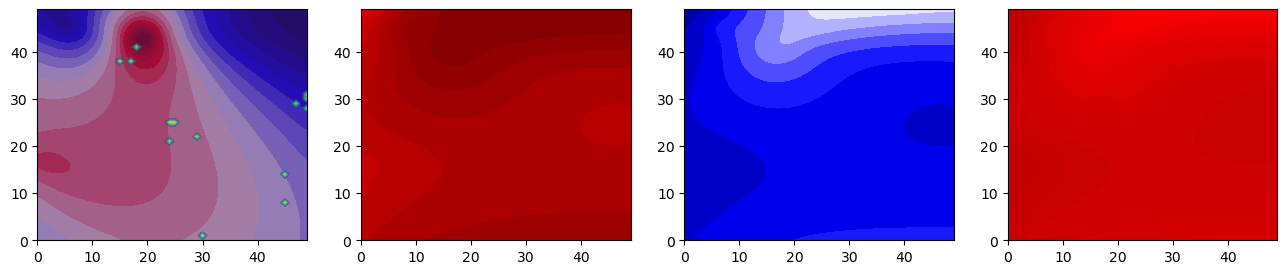

[0.00052686 0.01262393]


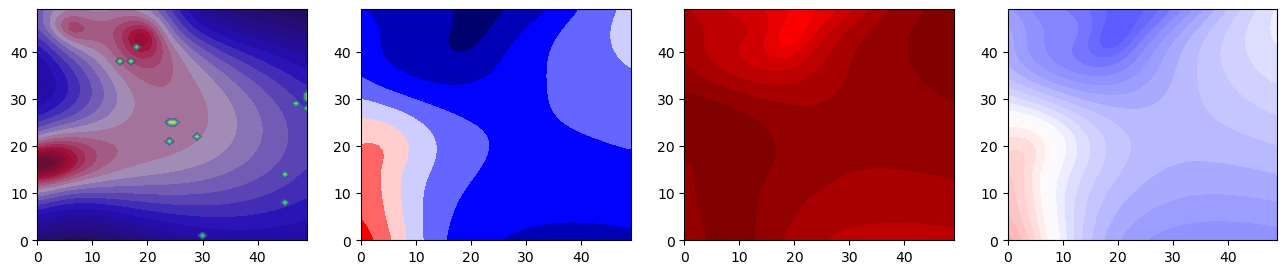

4 ........
6
2005-11-14 21:38:52.290000
38.1179 144.8999
291.3474144974988
[0.00102227 0.00445914]


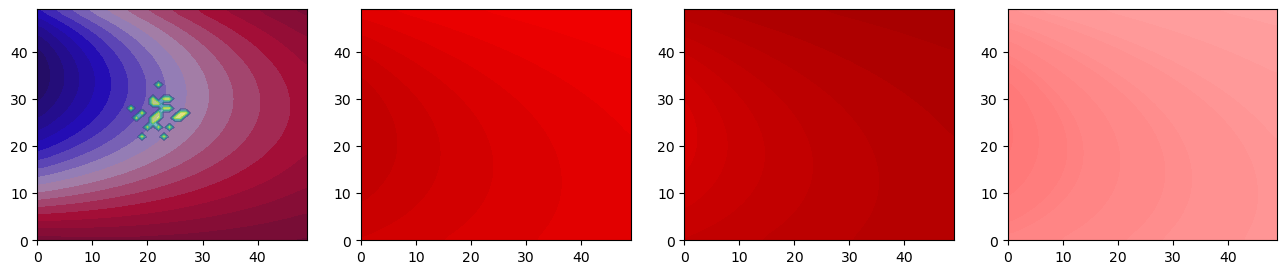

[0.00016973 0.00473791]


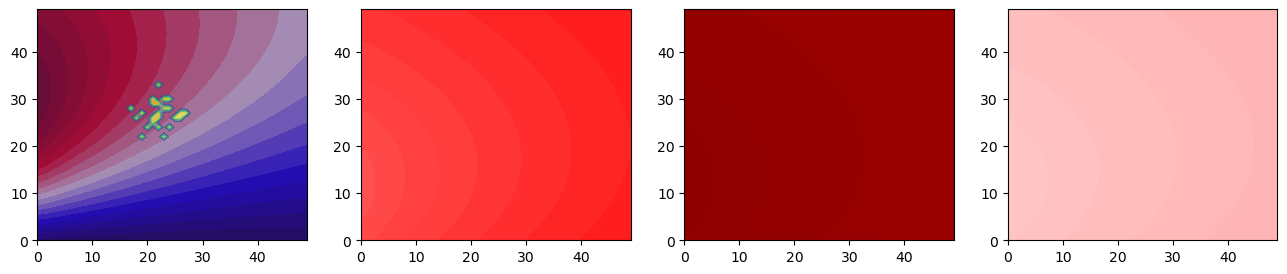

[0.00035738 0.00653524]


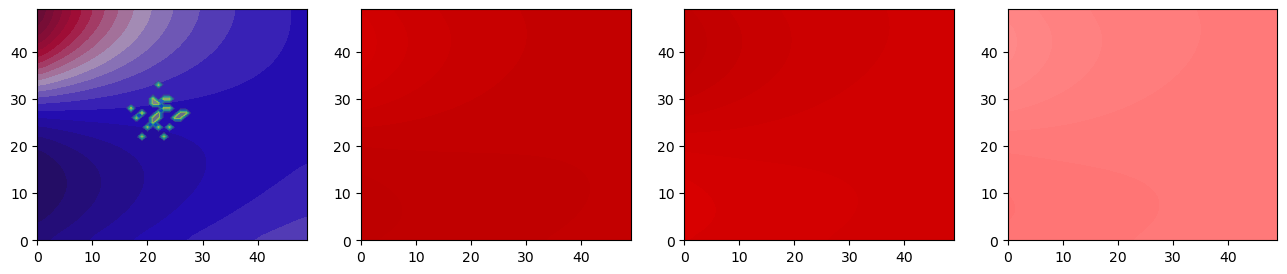

5 ........
9
2007-07-16 01:13:22.680000
37.4882 138.5357
14.834907000120996
[0.0004256  0.00855471]


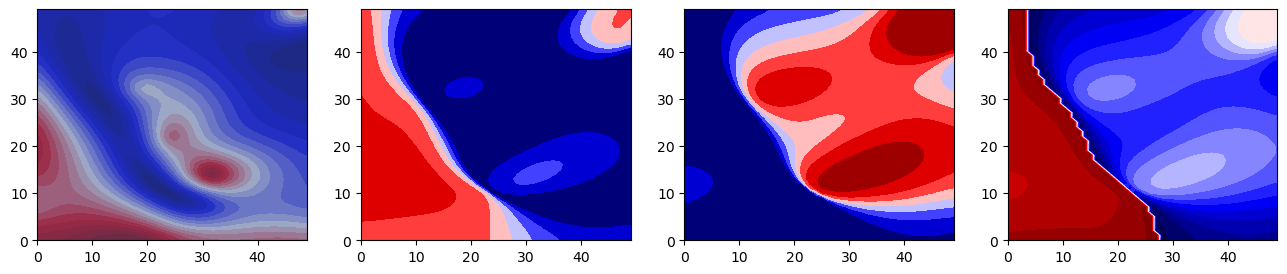

[0.00063225 0.00926002]


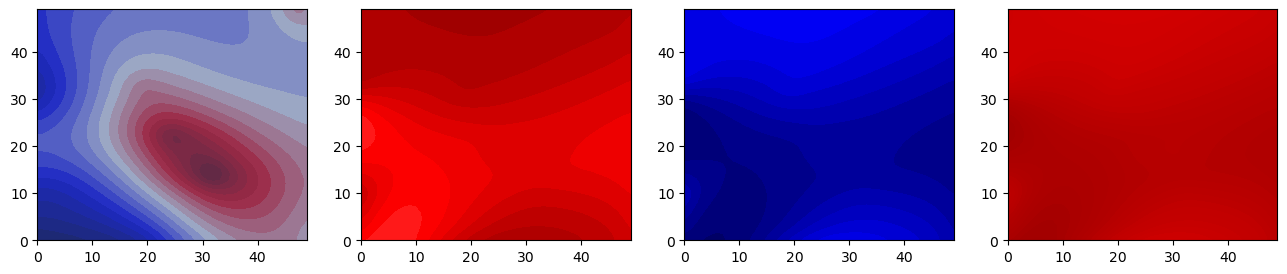

[0.00069352 0.11747207]


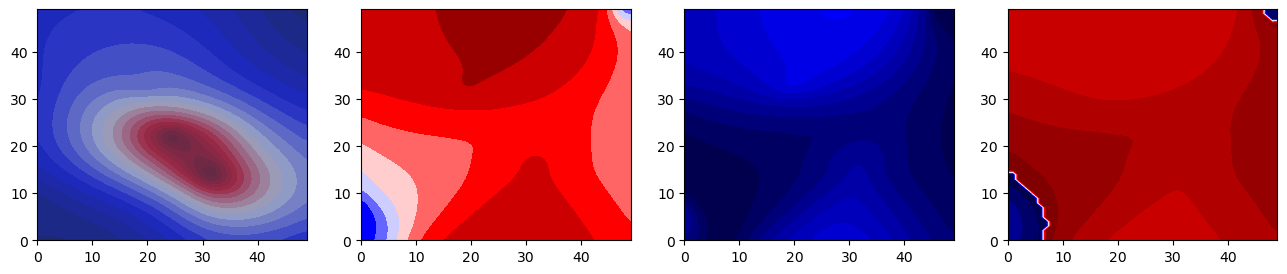

6 ........
10
2008-07-23 15:26:20.050000
39.7815 141.5357
23.823251780927663
[0.00013015 0.0034904 ]


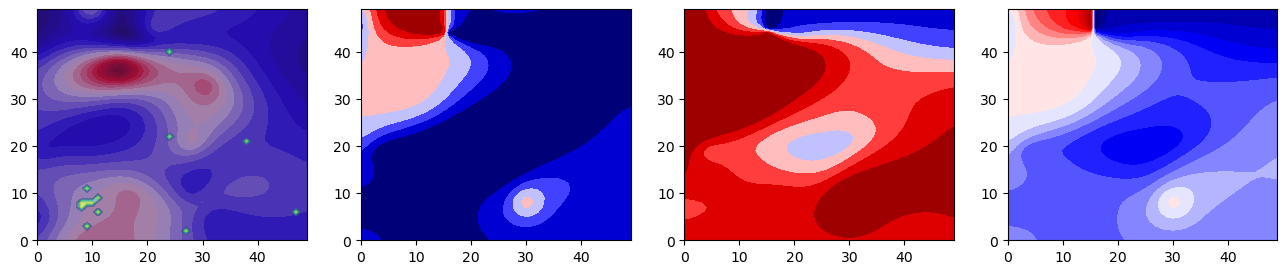

[0.00038791 0.01231153]


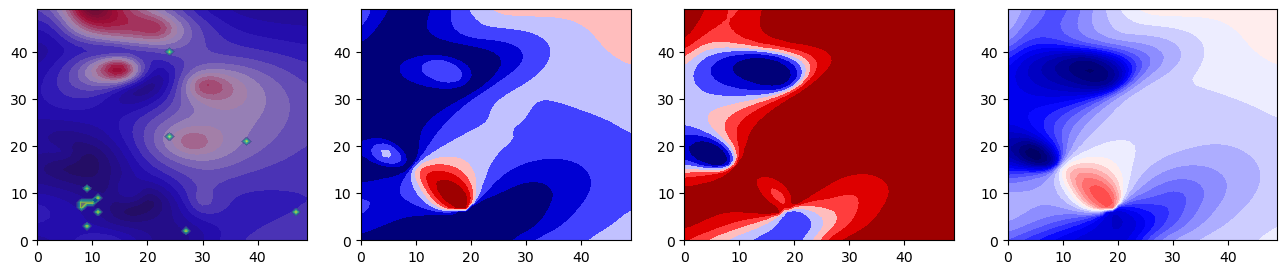

[9.50004868e-05 1.57255326e-02]


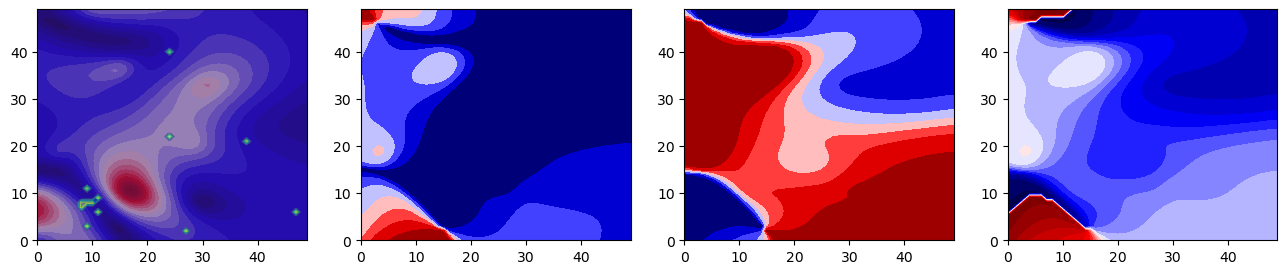

7 ........
11
2011-03-11 05:46:23.200000
38.2963 142.498
87.03156069392368
[6.76384406e-05 3.17253174e-02]


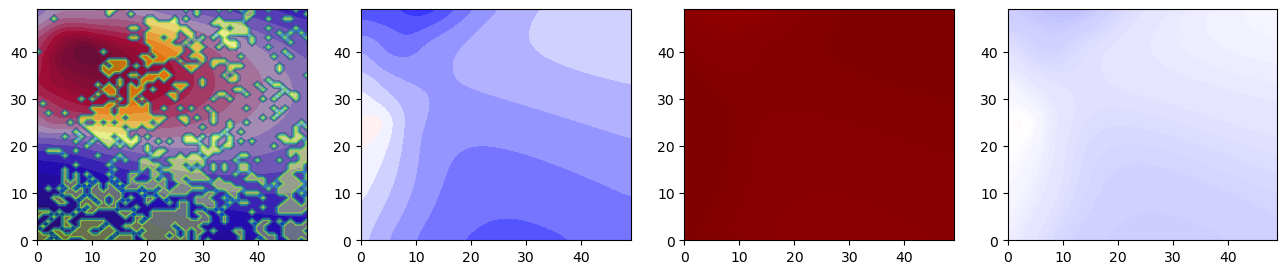

[8.01821651e-05 1.32335452e-02]


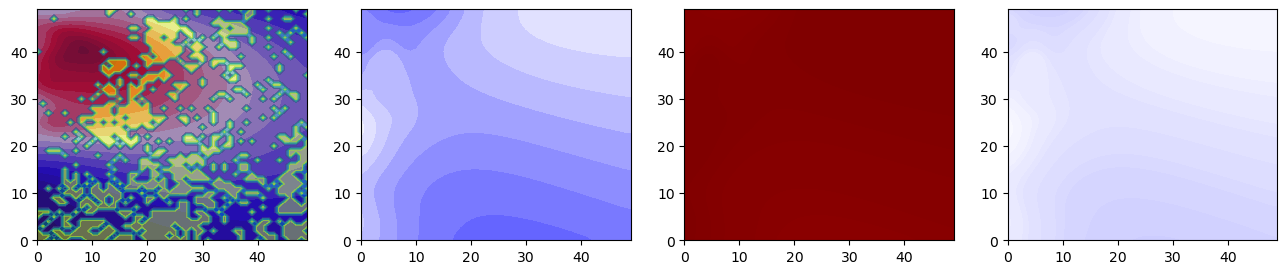

[7.32360381e-04 5.51689221e+00]


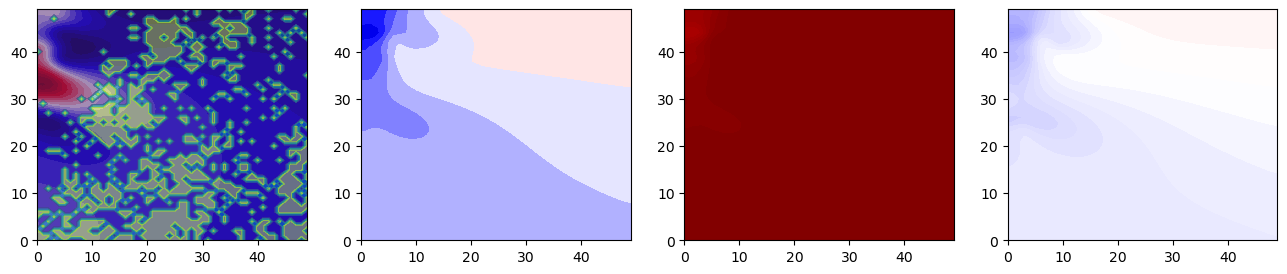

8 ........
12
2011-03-11 05:51:20.500000
37.31 142.24
120.94296075176469
[6.76384406e-05 3.17253174e-02]


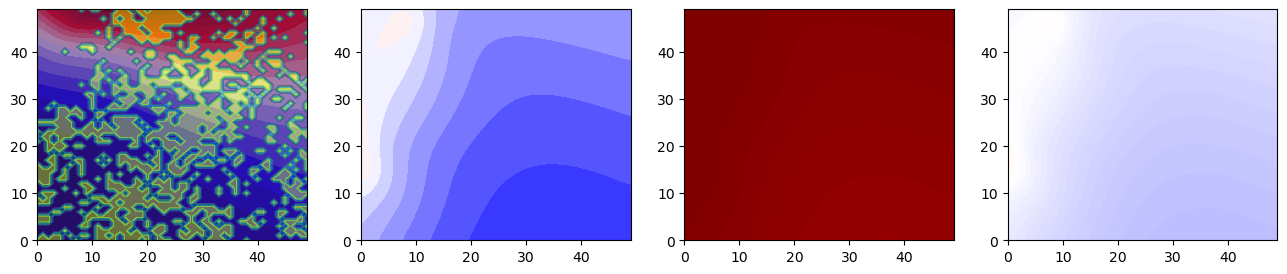

[8.01821651e-05 1.32335452e-02]


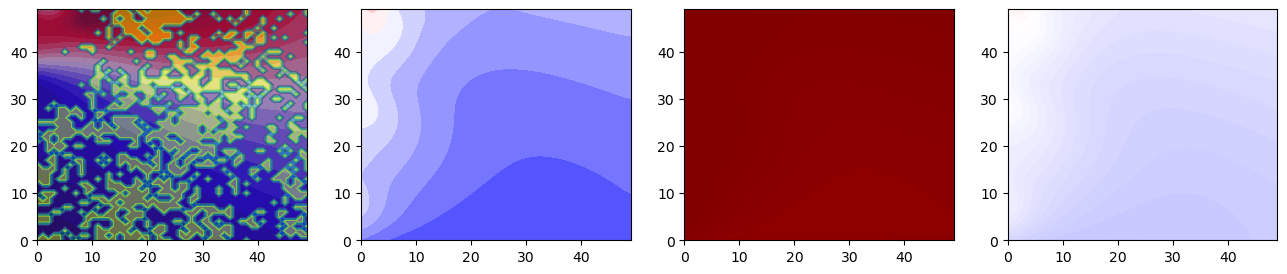

[7.32360381e-04 5.51689221e+00]


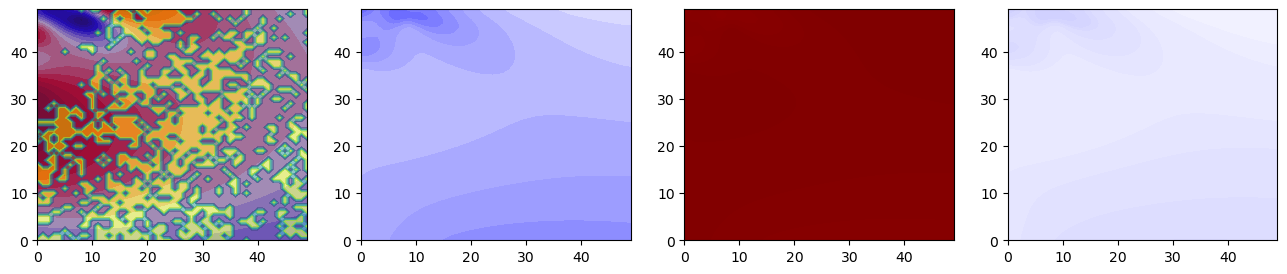

9 ........
13
2011-03-11 06:15:37.570000
36.2274 141.088
48.97600536985774
[6.76384406e-05 3.17253174e-02]


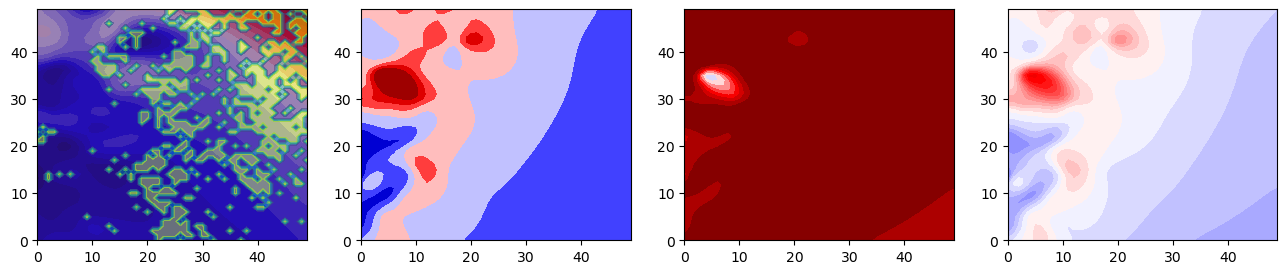

[8.01821651e-05 1.32335452e-02]


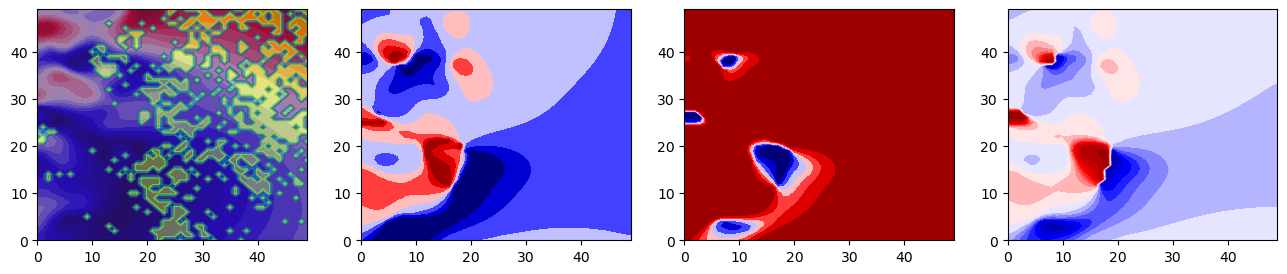

[7.32360381e-04 5.51689221e+00]


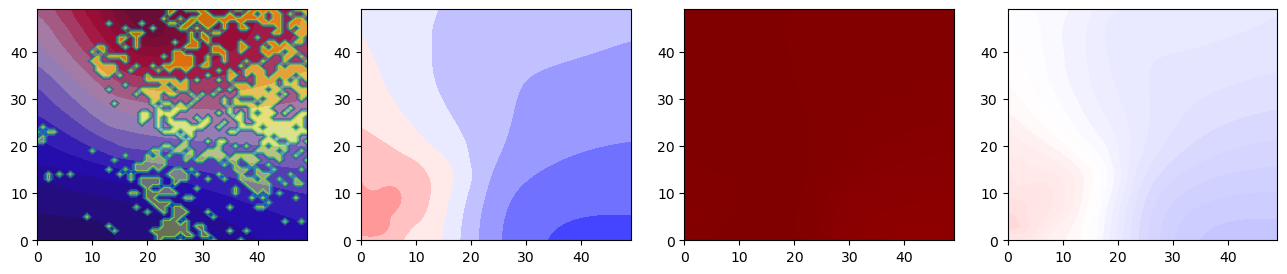

10 ........
14
2011-03-11 06:18:51.060000
36.0692 142.1388
123.28017167520922
[6.76384406e-05 3.17253174e-02]


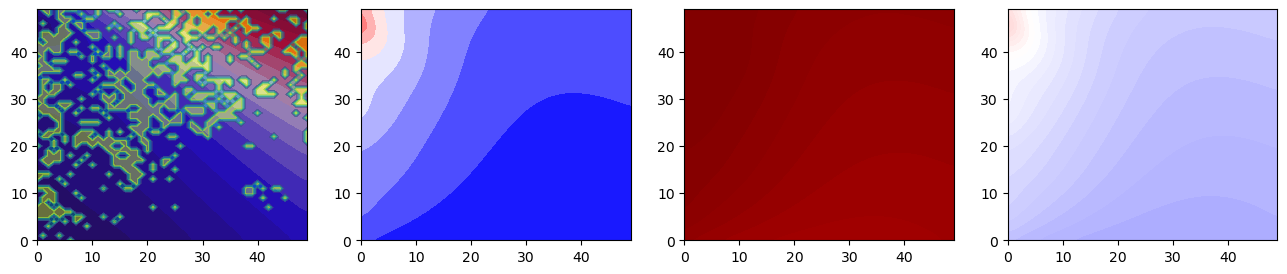

[8.01821651e-05 1.32335452e-02]


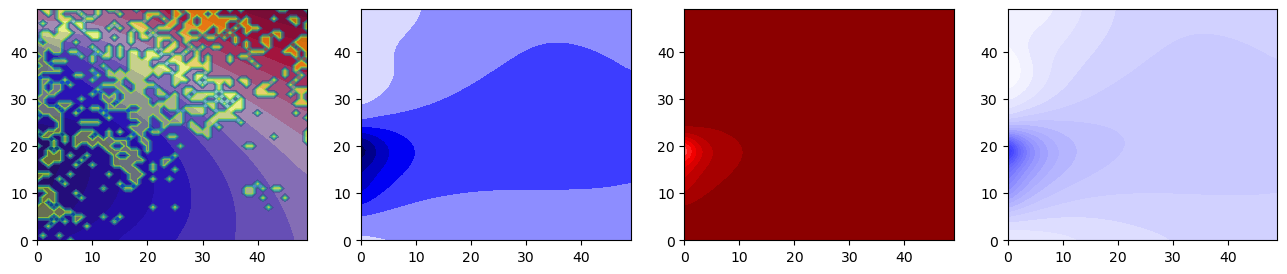

[7.32360381e-04 5.51689221e+00]


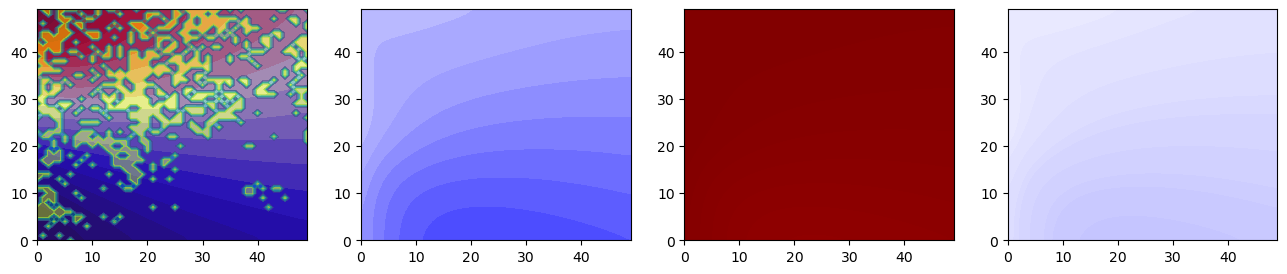

11 ........
15
2011-03-11 06:25:50.740000
38.051 144.6297
272.3793023712723
[0.00022896 0.03172532]


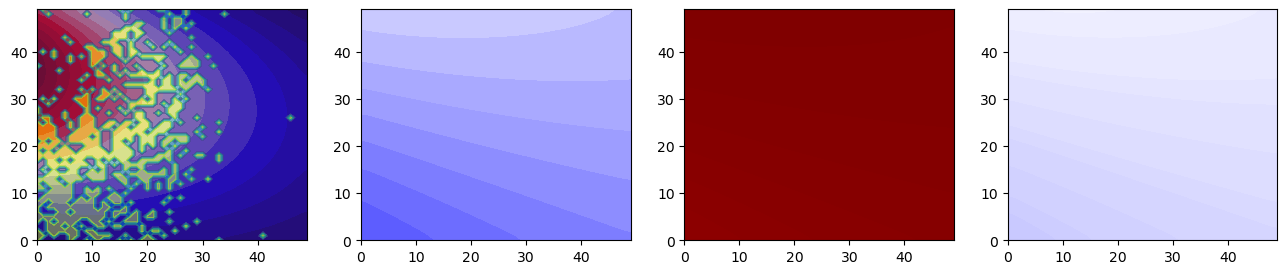

[0.00018339 0.01323355]


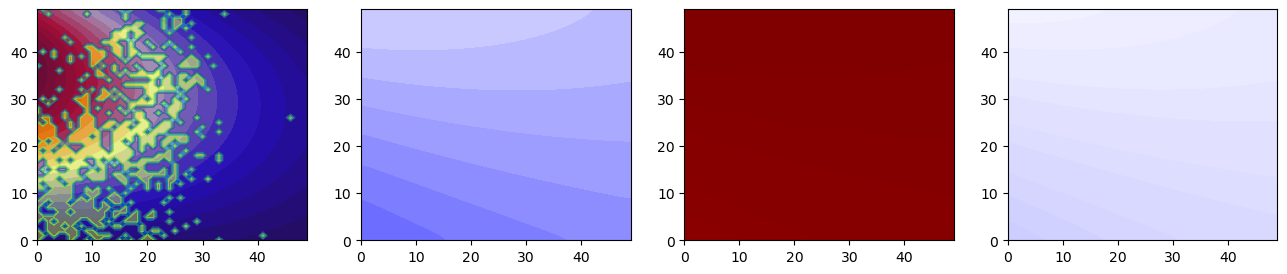

[7.32360381e-04 5.51689221e+00]


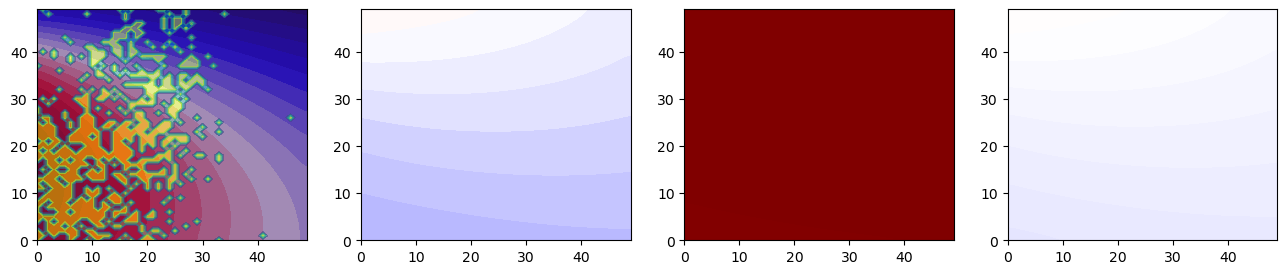

12 ........
16
2011-03-11 08:19:27.470000
36.1862 141.6639
90.2820737512751
[6.76384406e-05 3.17253174e-02]


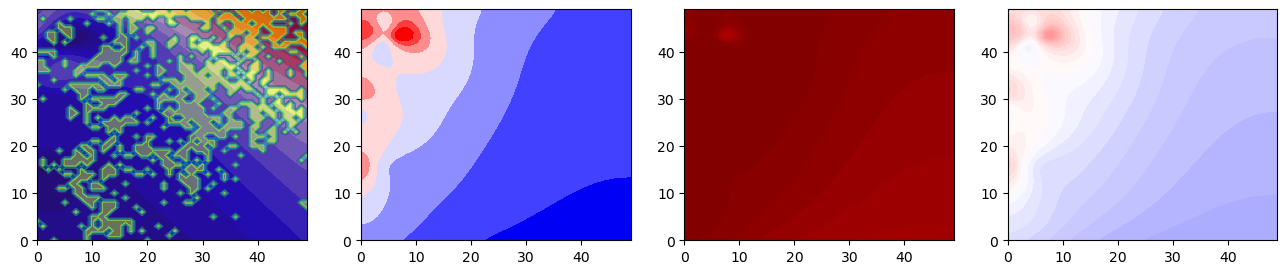

[8.01821651e-05 1.32335452e-02]


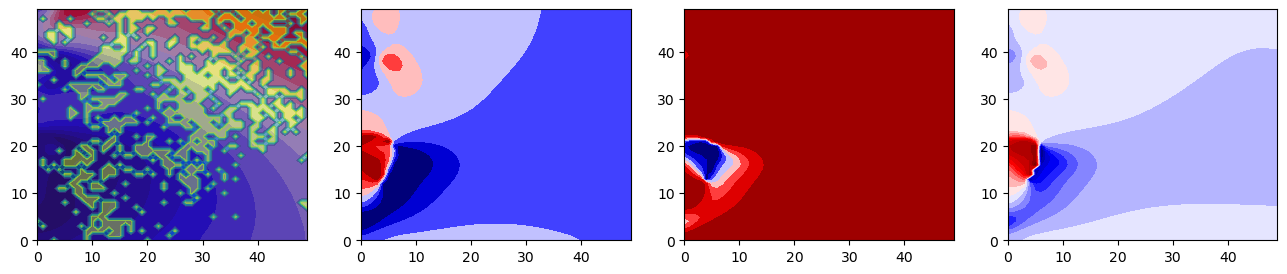

[7.32360381e-04 5.51689221e+00]


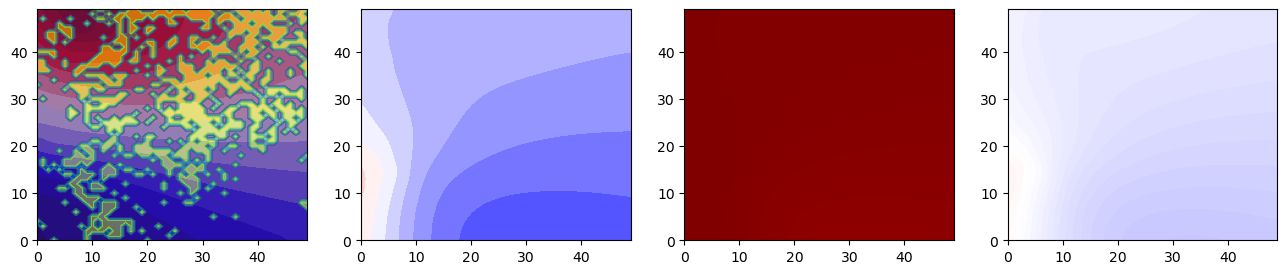

13 ........
17
2011-03-11 11:36:40.030000
39.2219 142.5316
56.096037563238255
[6.76384406e-05 3.17253174e-02]


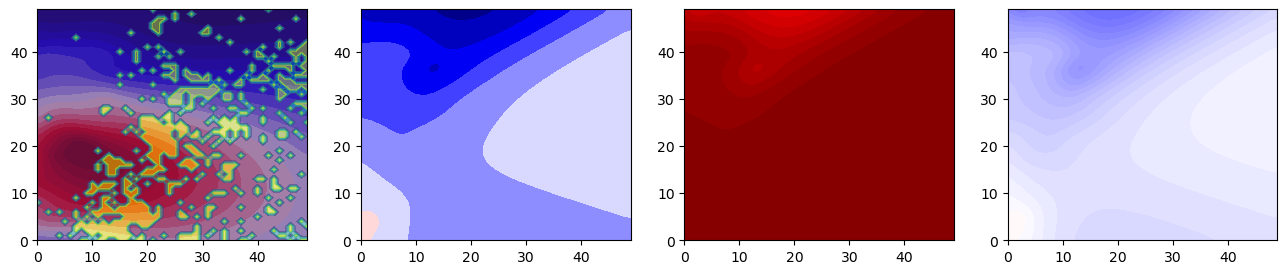

[8.01821651e-05 1.32335452e-02]


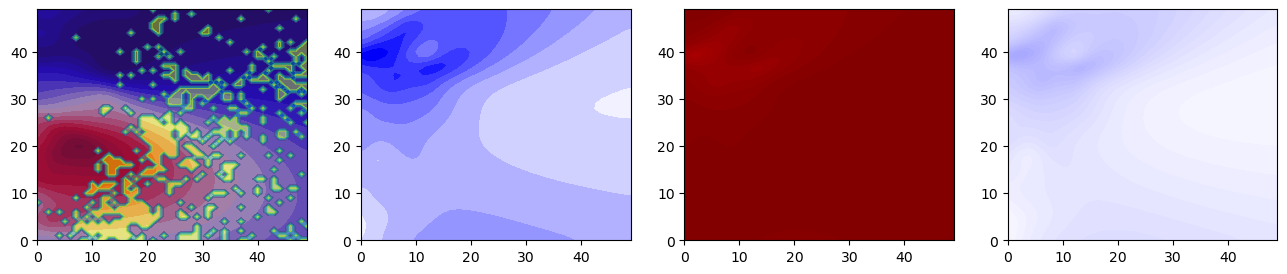

[7.32360381e-04 5.51689221e+00]


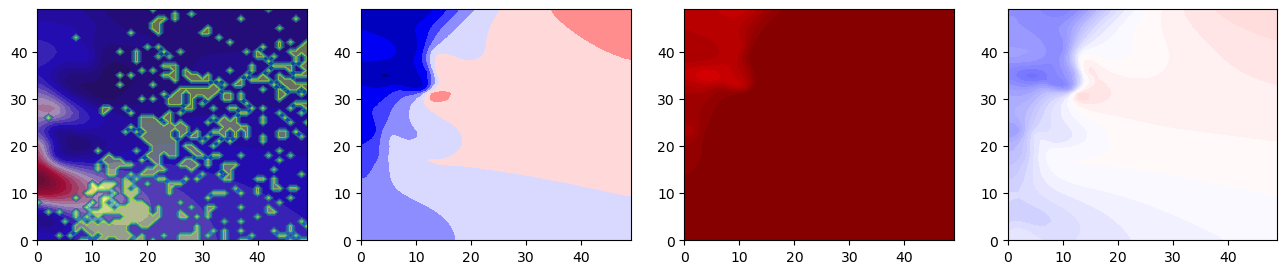

14 ........
18
2011-04-07 14:32:44.100000
38.2513 141.7296
46.90599620730431
[0.00014065 0.0095342 ]


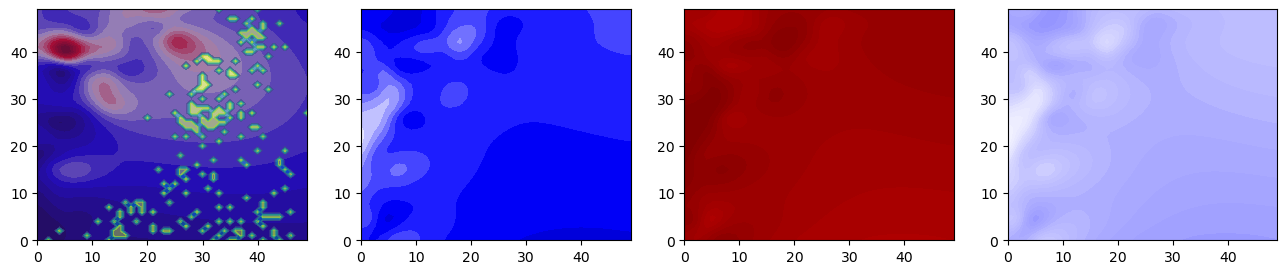

[0.00019891 0.01207897]


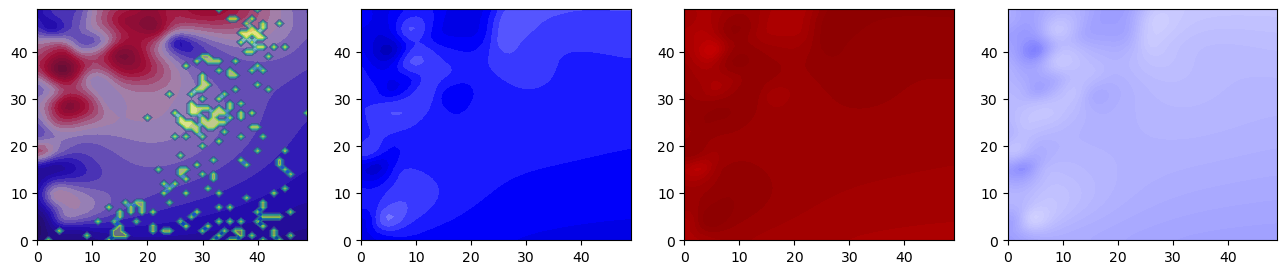

[0.00042342 0.02184494]


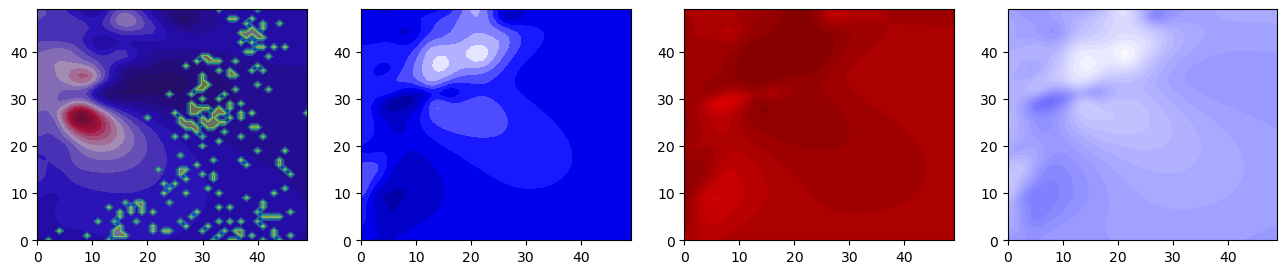

15 ........
19
2011-07-10 00:57:10.910000
38.0553 143.3016
159.77084643863773
[0.00013015 0.01696195]


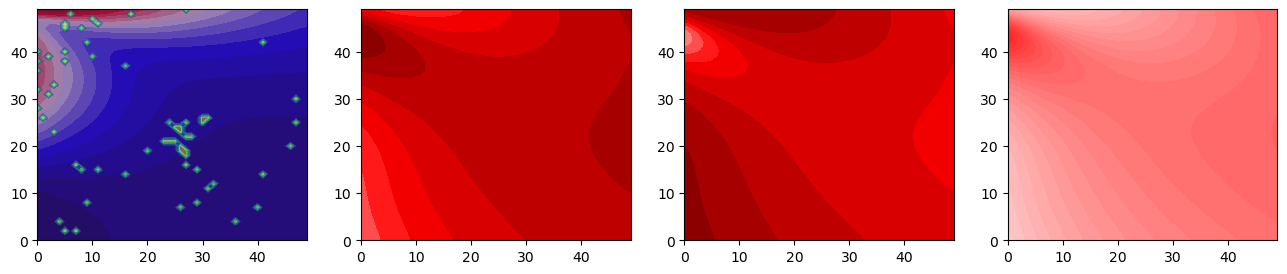

[7.86263021e-05 1.60356654e-02]


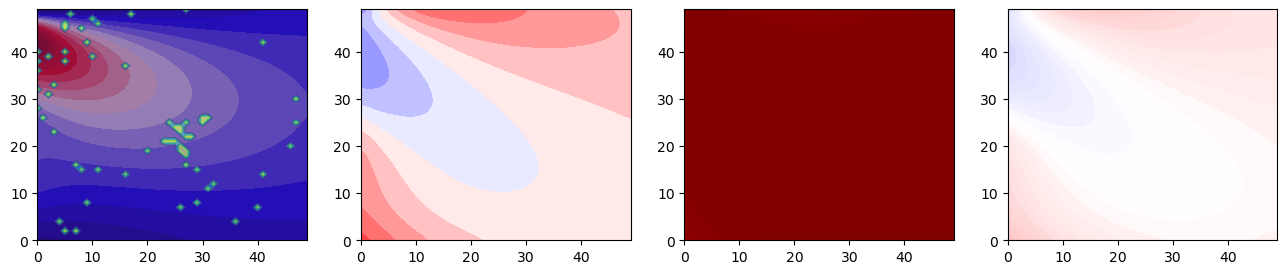

[0.00016973 0.00899023]


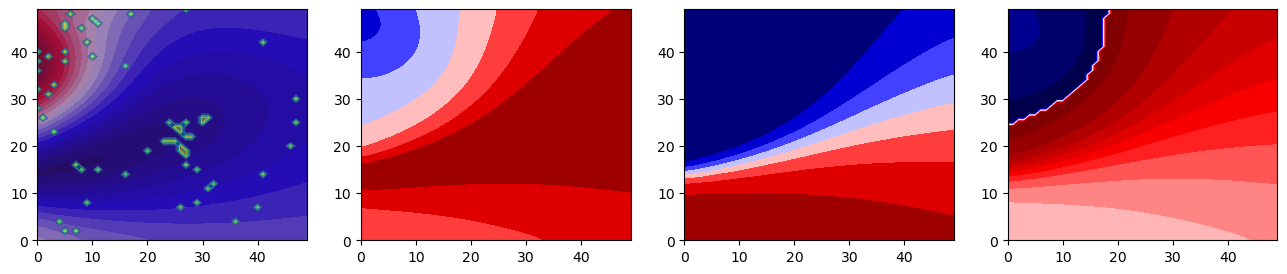

16 ........
20
2012-03-14 09:08:36.230000
40.842 145.0154
201.03435834624293
[0.00025356 0.00868763]


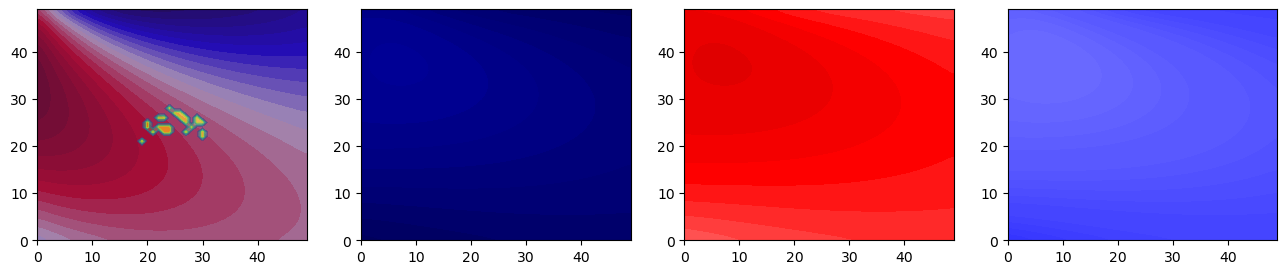

[0.00012432 0.00787299]


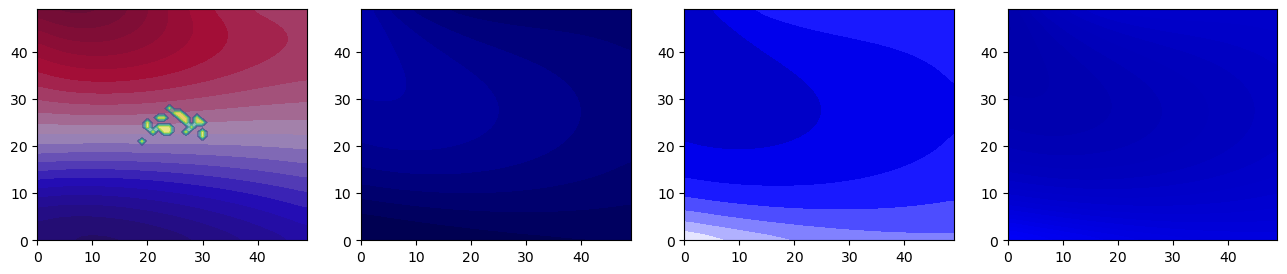

[0.00010252 0.00638507]


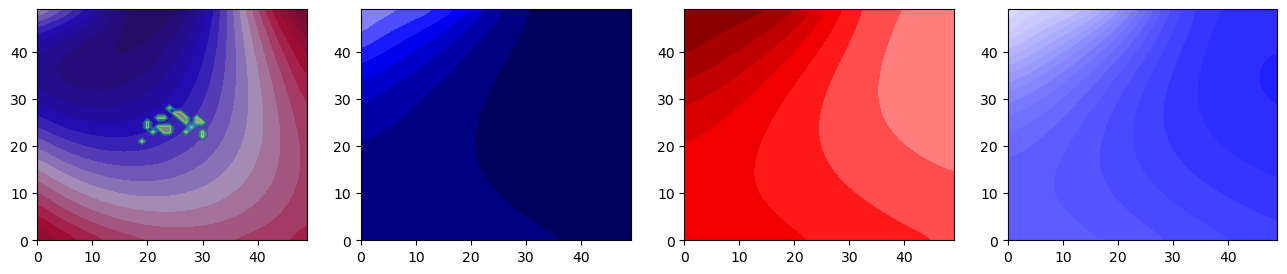

17 ........
21
2012-12-07 08:18:23.140000
37.8759 144.1609
237.55867643899583
[0.00012432 0.00901207]


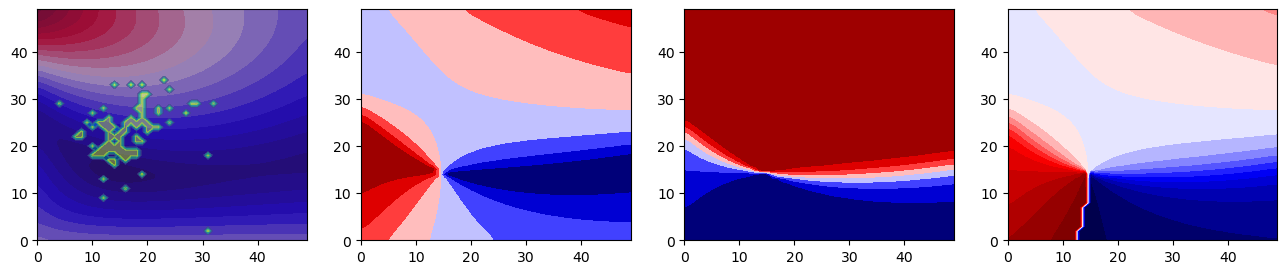

[7.45903289e-05 1.48137793e-02]


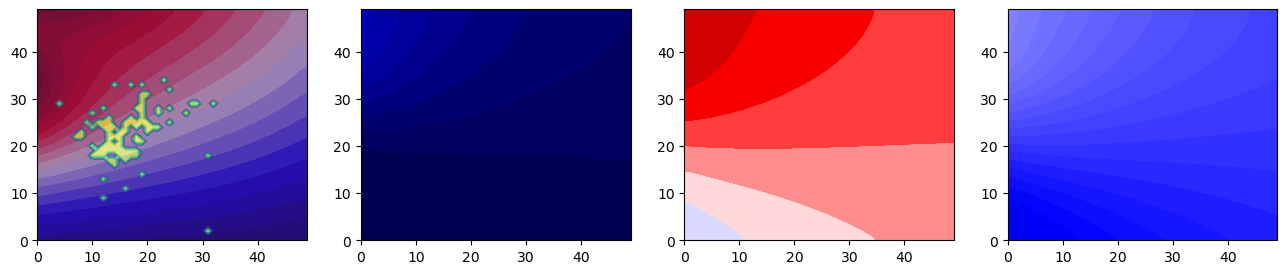

[7.86232852e-05 1.85961819e-02]


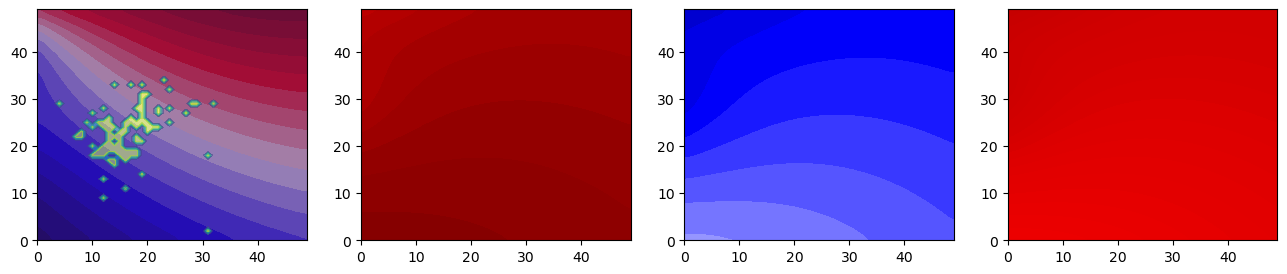

18 ........
22
2012-12-07 08:18:23.630000
37.8201 144.1594
238.82940643017315
[0.00012432 0.00901207]


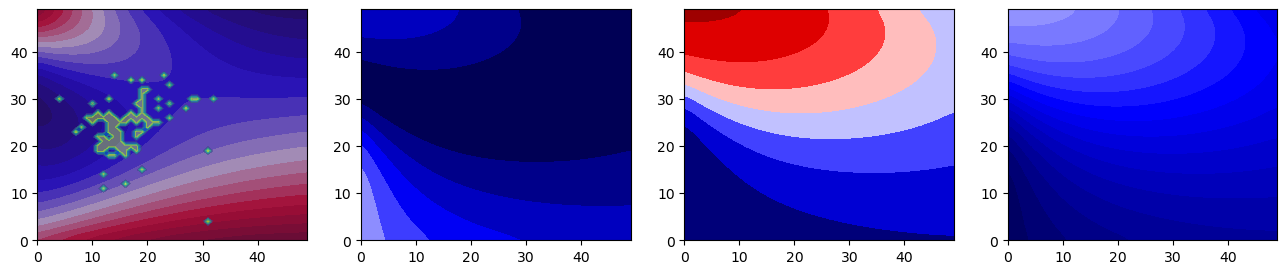

[7.45903289e-05 1.48137793e-02]


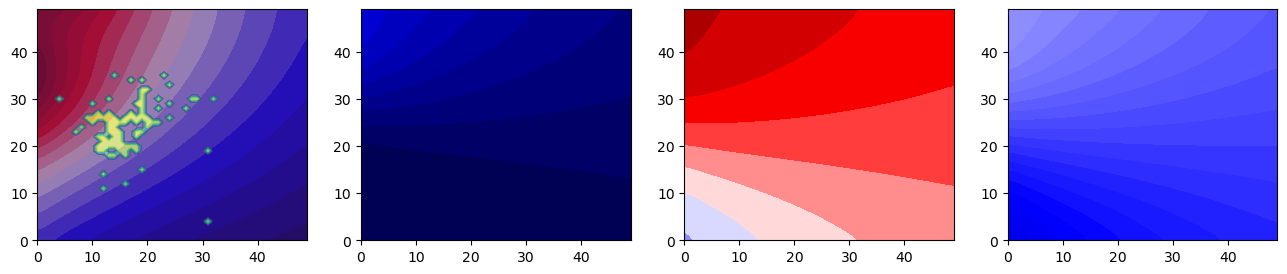

[7.86232852e-05 1.35686242e-02]


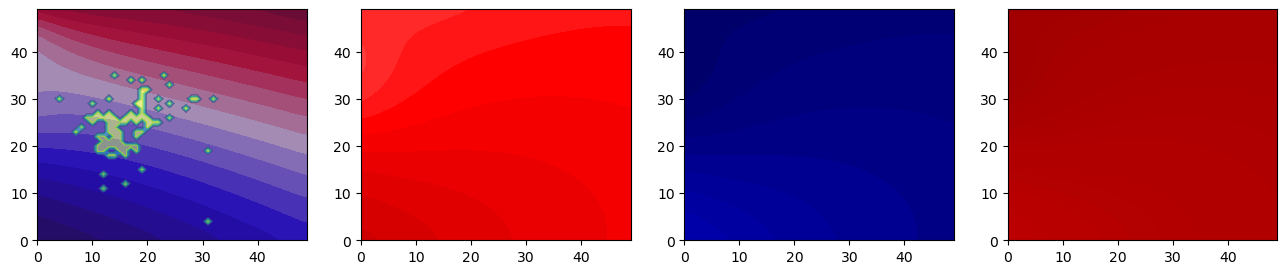

19 ........
24
2013-10-25 17:10:17.090000
37.1457 144.754
313.6337543983732
[0.00018903 0.00472736]


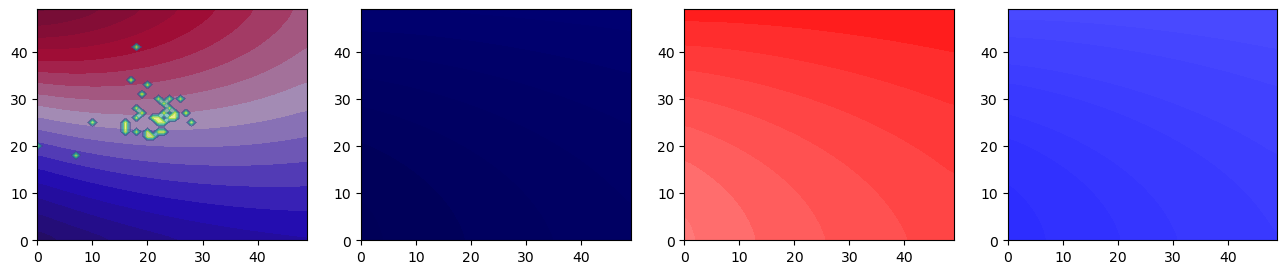

[3.51643006e-05 5.85491496e-03]


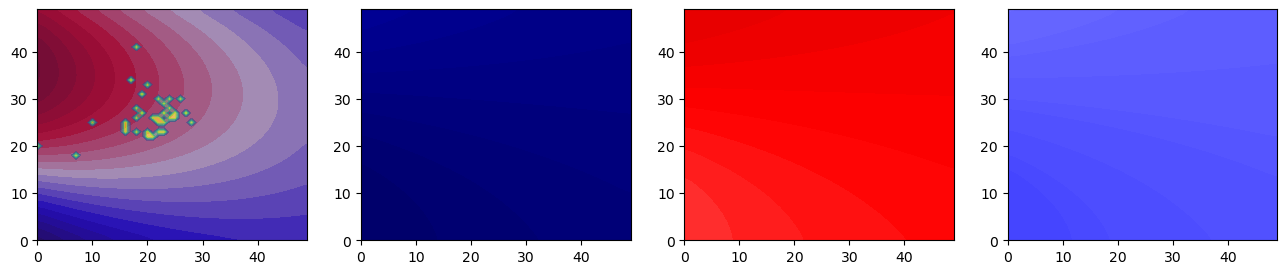

[6.29063828e-05 1.09470529e-02]


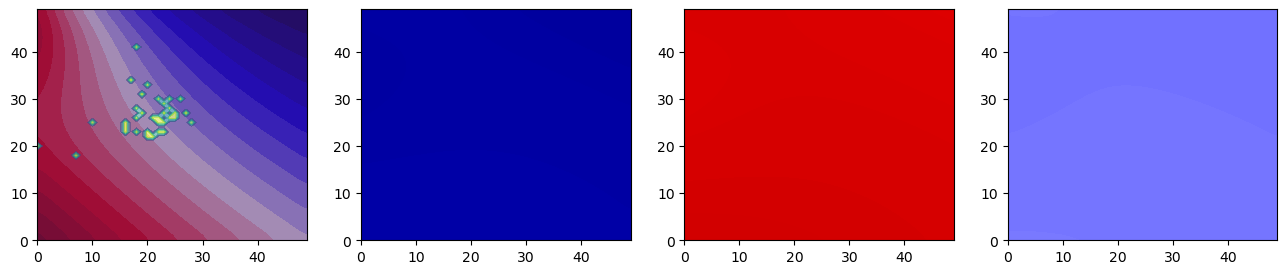

20 ........
25
2014-07-20 18:32:48.350000
44.6329 148.7298
273.2762126696636
[0.0001619  0.00825233]


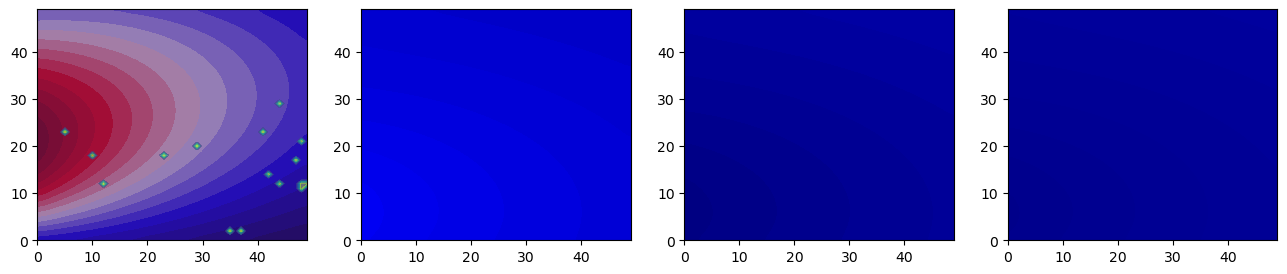

[7.03241034e-05 6.91654807e-03]


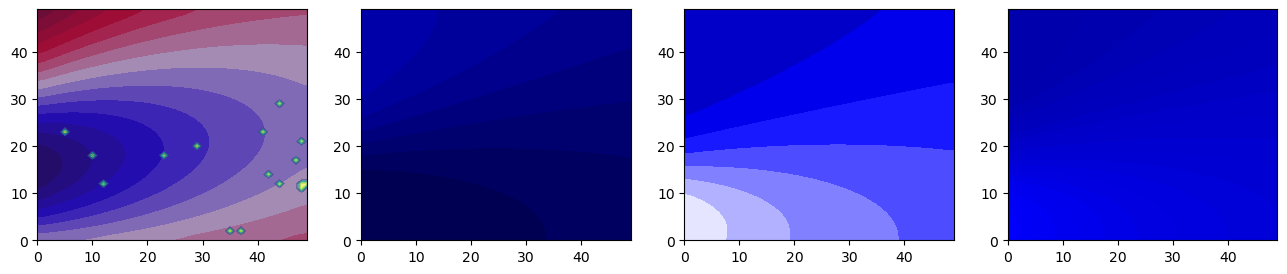

[1.11196911e-05 4.42914240e-03]


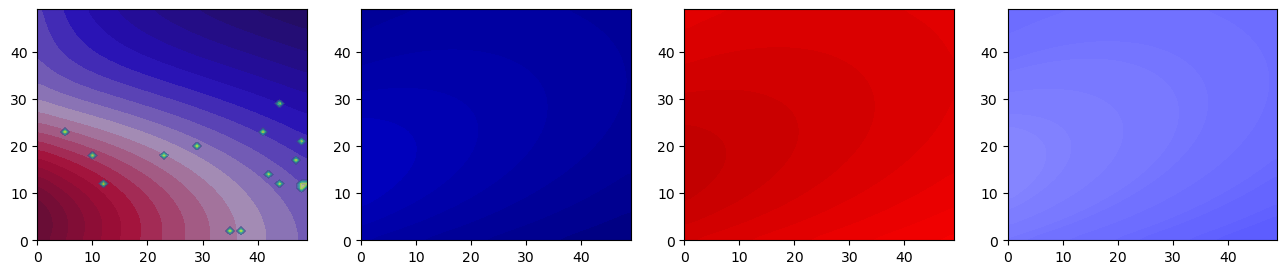

21 ........
26
2016-01-14 03:25:33.620000
42.0438 142.6972
21.913765636030497
[0.0001793  0.02100196]


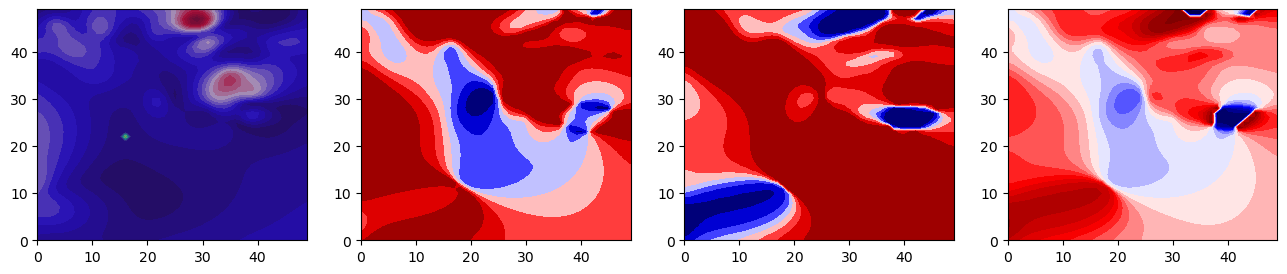

[0.00030835 0.0403875 ]


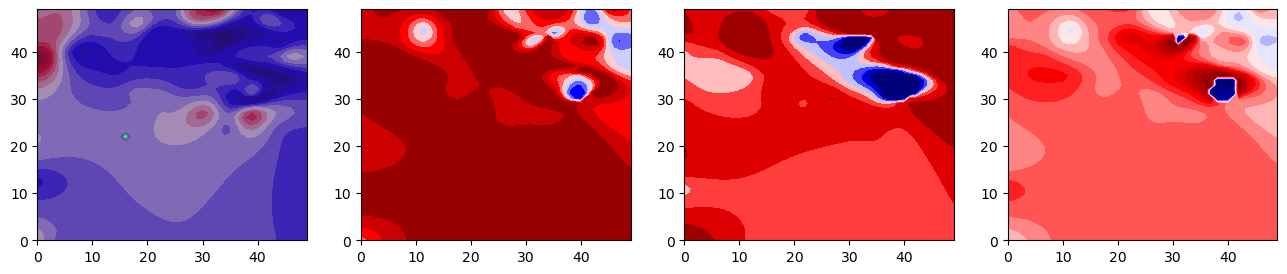

[8.09519221e-05 1.17857055e-02]


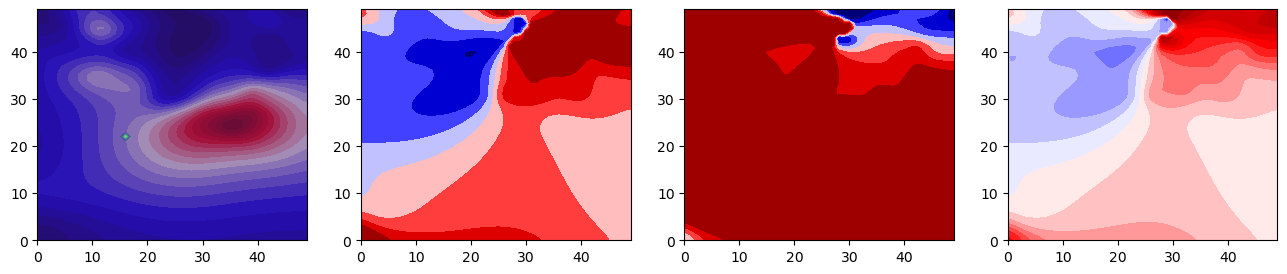

22 ........
27
2016-11-21 20:59:48.560000
37.2764 141.3754
33.37360046925382
[0.00012282 0.02247   ]


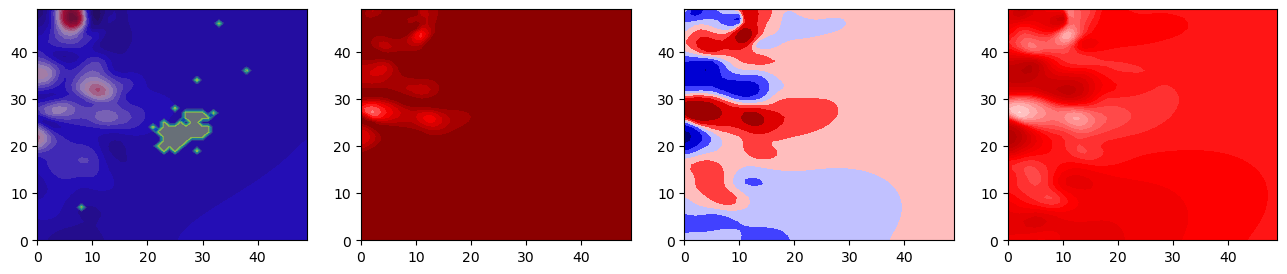

[0.00033617 0.0221585 ]


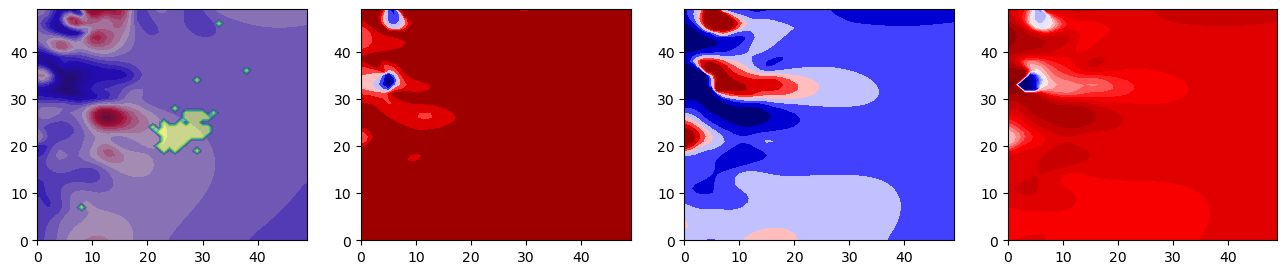

[8.01821651e-05 1.63382016e-02]


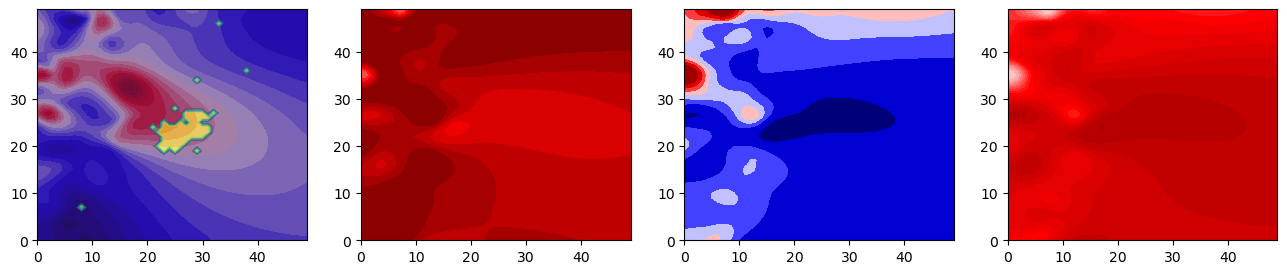

23 ........
28
2018-09-05 18:08:01.060000
42.639 142.0064
15.383460535737704
[0.00017581 0.01006041]


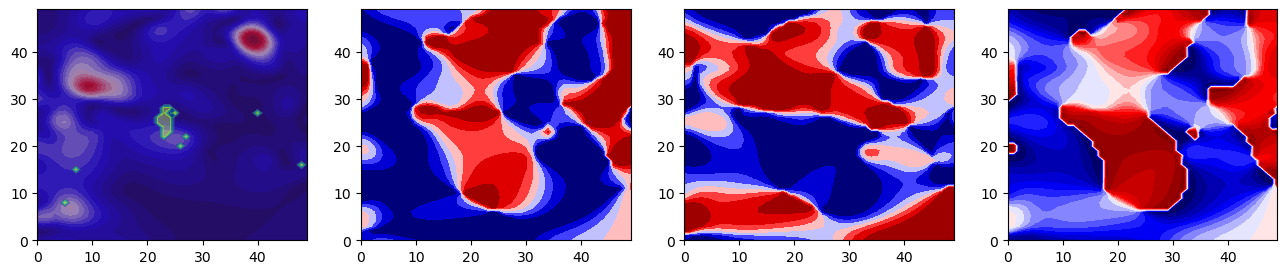

[8.96472682e-05 2.56049704e-02]


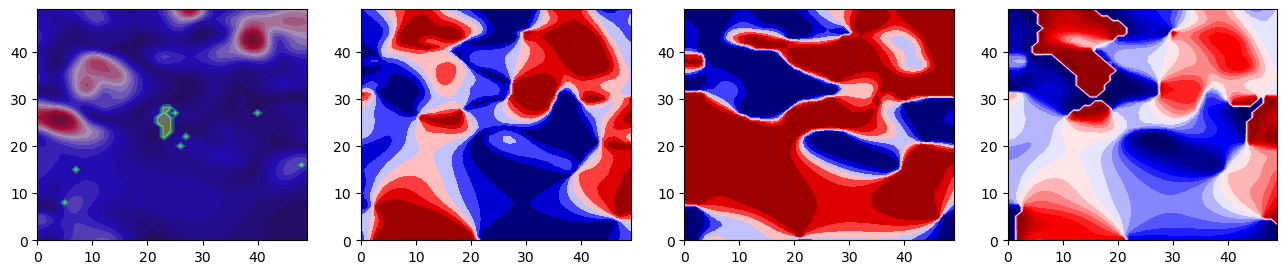

[0.00024864 0.03341541]


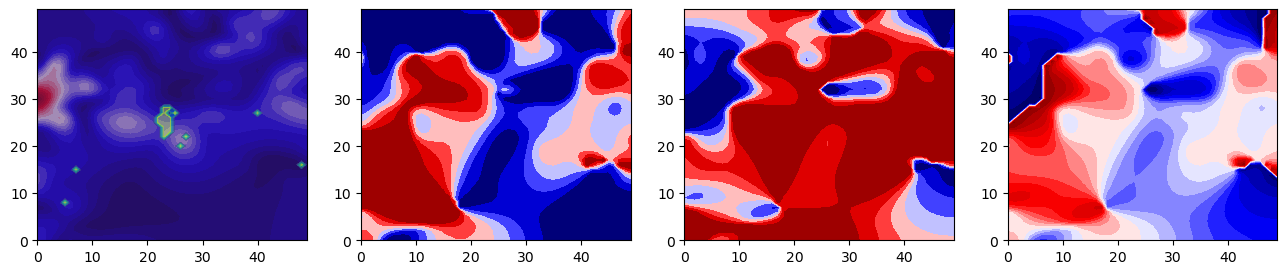

24 ........
29
2020-02-13 10:33:44.930000
45.5278 148.8407
333.6612356425285
[0.00017009 0.00382329]


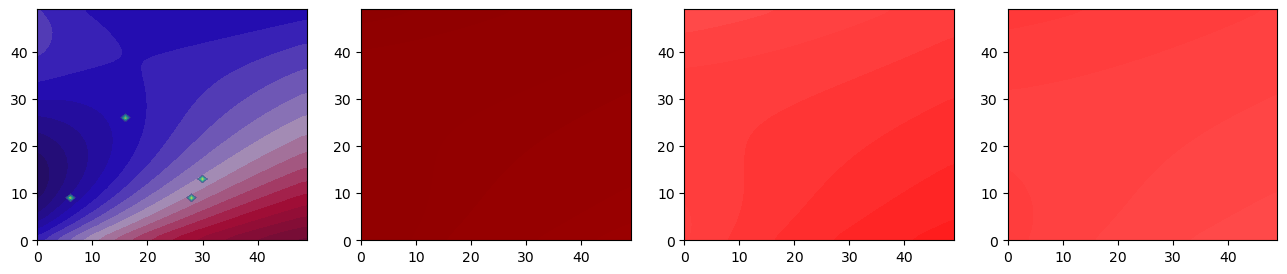

[0.00021156 0.00973639]


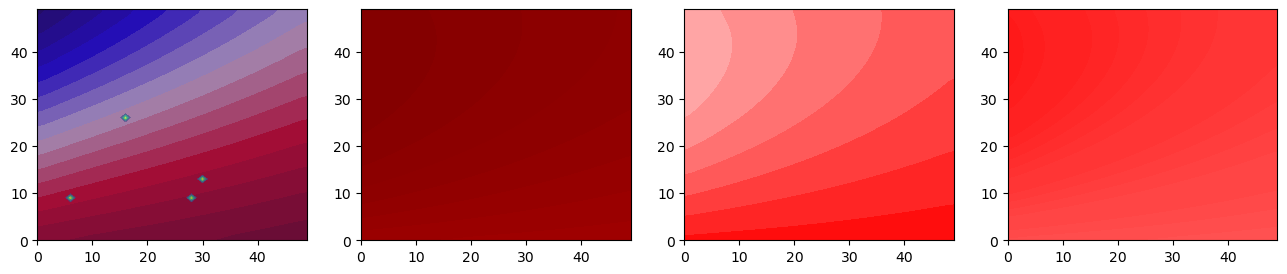

[0.00034038 0.01166055]


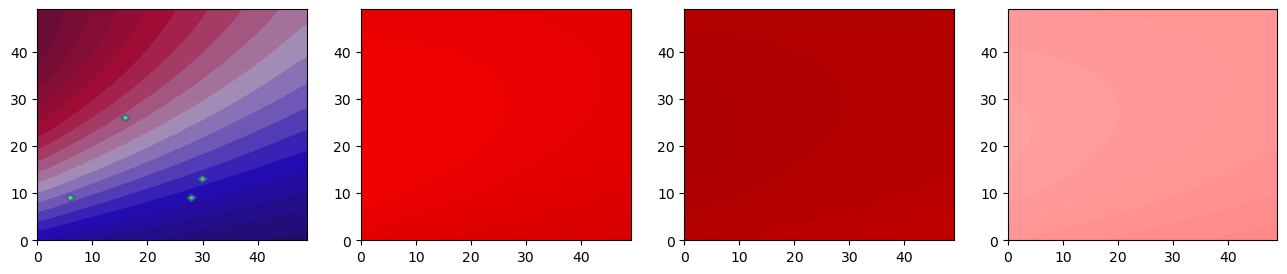

25 ........
30
2021-02-13 14:07:50.460000
37.6714 141.7242
65.044376338015
[6.67165665e-05 1.53276010e-02]


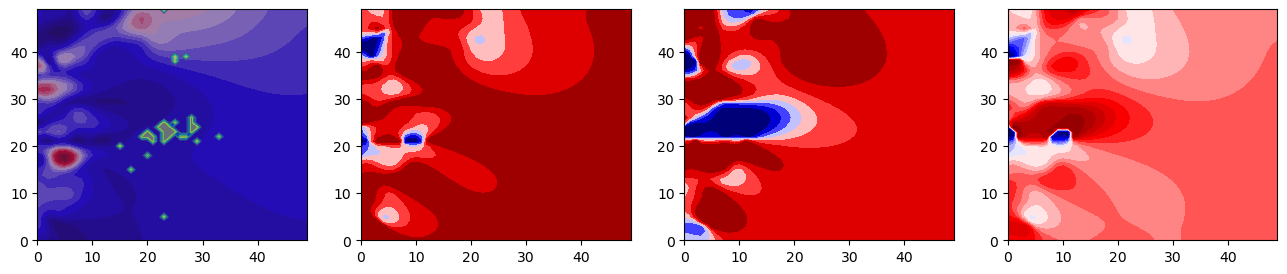

[0.00019419 0.01063936]


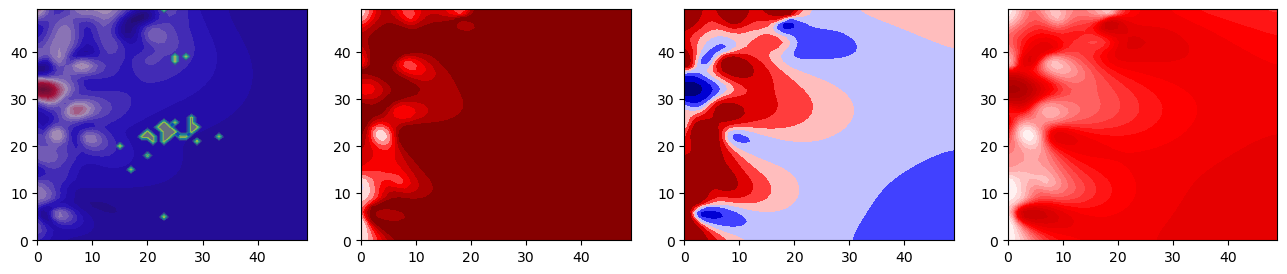

[3.51650501e-05 9.58963151e-03]


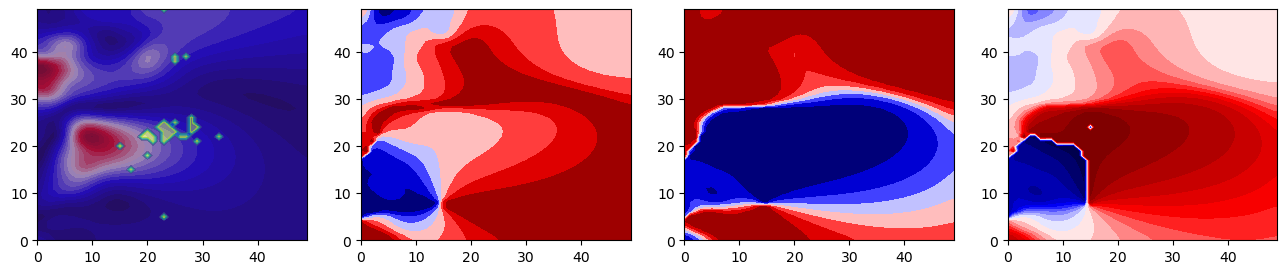

26 ........
31
2021-03-20 09:09:45.570000
38.4691 141.5253
2.969942118259657
[0.00015607 0.02119024]


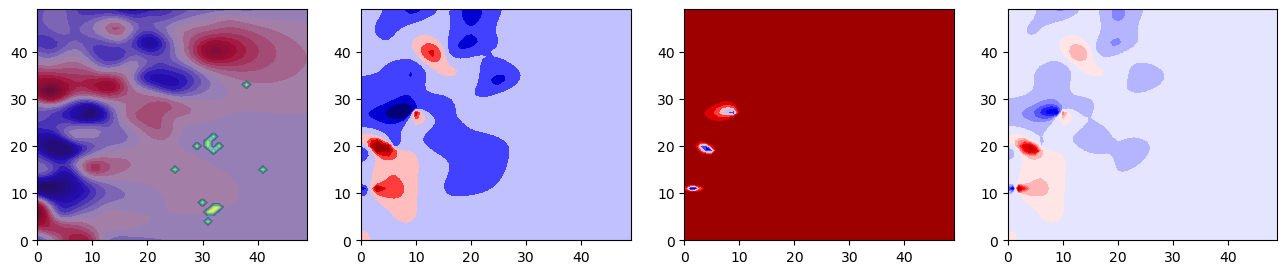

[0.0001424  0.02255536]


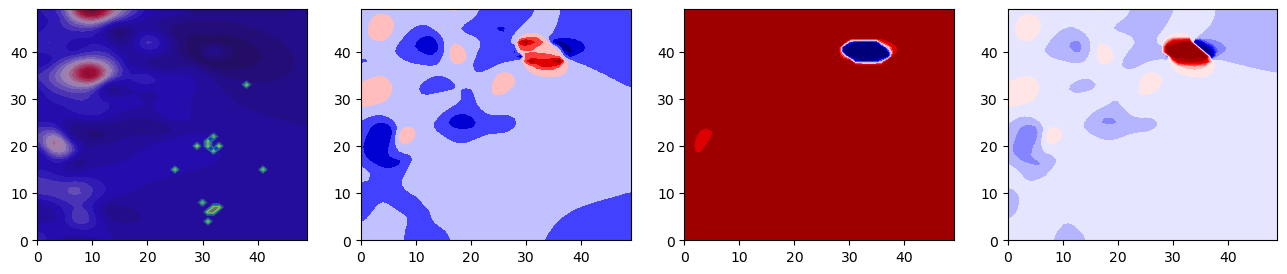

[0.00070781 0.02410777]


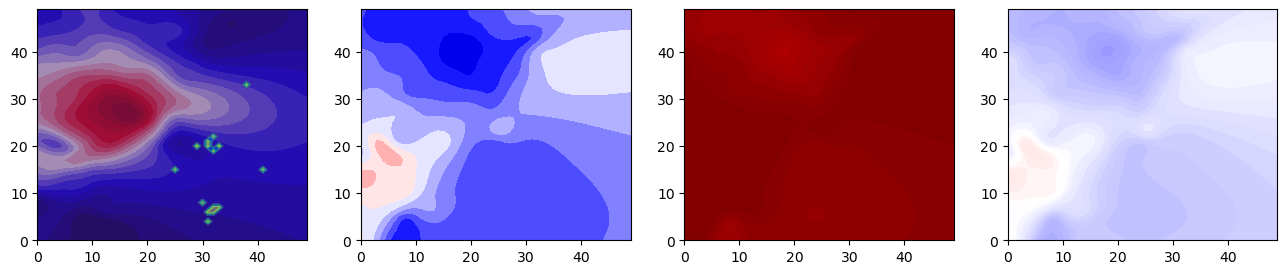

27 ........
32
2022-03-16 14:36:30.990000
37.7132 141.5793
53.12303142715477
[0.00022267 0.02120753]


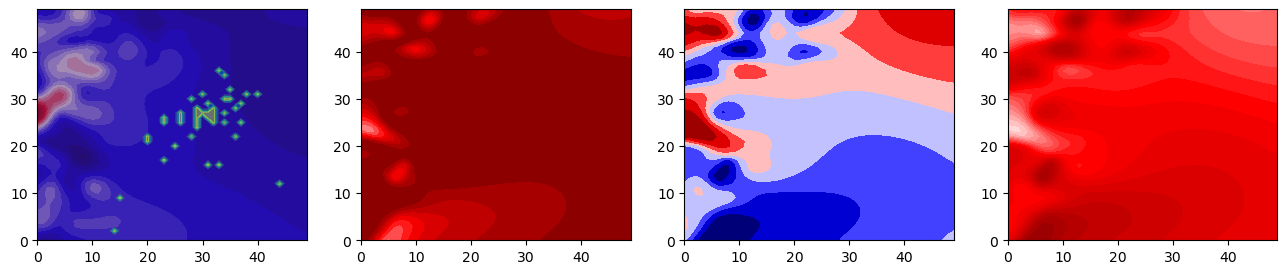

[0.00011609 0.01453517]


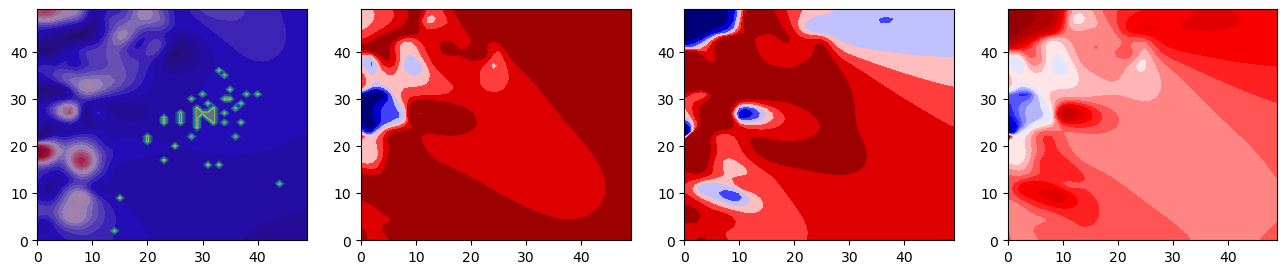

[4.97287704e-05 1.67651960e-02]


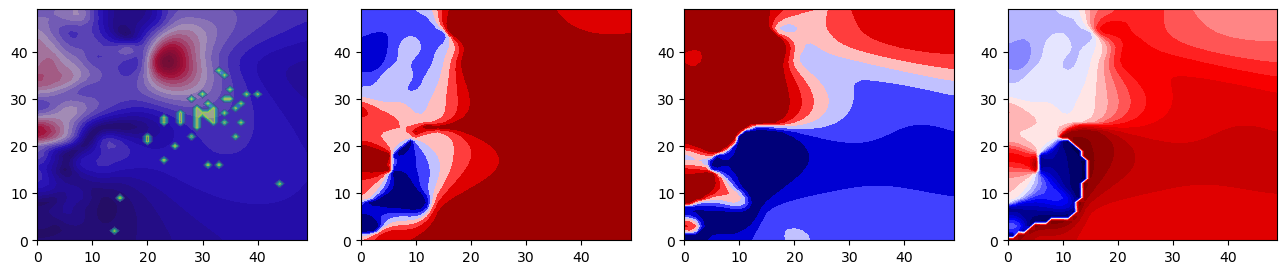

28 ........


In [24]:
from scipy.ndimage import gaussian_filter
from scipy.spatial import Delaunay, ConvexHull
r0 = 6371
aftershocks_day = 30
aftershocks_r = 500
n_past_days = 3
past_days_dt = np.timedelta64(n_past_days, 'D')
min_stats_num = 3
#input_d = []
#output_d = []
#days_d = []
cell_size_rads = 5/r0
cell_size_degs = 180*cell_size_rads/np.pi
image_half_size = 25
tot_found = 0
for qid, item in stats_quakes.items():
    quake_day = np.datetime64(item[0]).astype('datetime64[D]')
    
    x0s = [] 
    vels = []
    for name in item[-1]:
        data = stats_data[name]
        positions = data[(data.date>=  quake_day-past_days_dt)*(data.date <= quake_day)][['lat','lon']].values.astype('float64')
        if(positions.shape[0] == n_past_days+1):
            init_pos = data.loc[0,['lat','lon']].values.astype('float64')
            displacements = r0*1e3*(positions - init_pos)*np.pi/180 #units in meters
            velocities = np.diff(displacements, axis=0)
            x0s.append(init_pos[None,:])
            vels.append(velocities[None,:])
    if(len(x0s)> min_stats_num):
        x0s = np.concatenate(x0s, axis=0)
        vels = np.concatenate(vels, axis=0)
        #print(vels.shape)
        #delStats = Delaunay(x0s)
        day_mask = (reference_catalog.date.astype('datetime64[D]') >= quake_day + np.timedelta64(1,'D'))*(reference_catalog.date.astype('datetime64[D]') <= quake_day + np.timedelta64(aftershocks_day,'D'))
        pos_mask = haversine_distances(np.radians(reference_catalog[['lat','lon']].values), np.radians(np.array([item[1], item[2]]))[None,:])[:,0] <= aftershocks_r/r0
        if(use_custom):
            aftershocks = fit_catalog[(fit_catalog.qid == qid)*(fit_catalog.type==2)].reset_index(drop=True)
        else:
            aftershocks = reference_catalog[pos_mask*day_mask].copy().reset_index(drop=True)
        if(len(aftershocks)>1):
            #print(x0s, item[-1])
            print(qid)
            print(item[0])
            print(item[1], item[2])
            print(np.min(r0*haversine_1d(np.radians(x0s), np.radians(np.array([item[1],item[2]])))))
            vels_mean = vels.mean(axis=0)
            vels_std = vels.std(axis=0)
            vels_fit = (vels-vels_mean[None,:])/vels_std[None,:]
            
            
            
            fit_lat_origin = item[1] -cell_size_degs*image_half_size
            fit_lon_origin = item[2] -cell_size_degs*image_half_size
            
            
            #aftershocks['M0'] = 10**((3/2)*aftershocks.mag.values)
            #as_lats = np.floor(aftershocks.lat.values.min()),  np.ceil(aftershocks.lat.values.max())
            #as_lons= np.floor(aftershocks.lon.values.min()),  np.ceil(aftershocks.lon.values.max())
            #print(as_lats, as_lons)
            #as_lats = np.floor(item[1]-2), np.ceil(item[1]+2) 
            #as_lons = np.floor(item[2]-2), np.ceil(item[2]+2) 
            #print(as_lats, as_lons)
            #as_rows = math.ceil((as_lats[1] - as_lats[0])/cell_size_degs)
            #as_cols = math.ceil((as_lons[1] - as_lons[0])/cell_size_degs)
            #print(as_lats, as_lons, as_rows, as_cols)
            discr_as_locs = np.floor((aftershocks[['lat','lon']].values-np.array([fit_lat_origin,fit_lon_origin])[None,:])/cell_size_degs).astype('int')
            discr_as_locs_mask = (discr_as_locs[:,0]>=0)*(discr_as_locs[:,0] < 2*image_half_size)*(discr_as_locs[:,1]>=0)*(discr_as_locs[:,1] < 2*image_half_size)
            as_mask = np.zeros((2*image_half_size,2*image_half_size ), dtype=int)
            as_mask[discr_as_locs[discr_as_locs_mask,0], discr_as_locs[discr_as_locs_mask,1]] = 1
            
            
            
            for time_index in range(0, vels.shape[1]):
                v_interp, bf = fit_constrained(x0s*np.pi/180, vels_fit[:,time_index,:],
                                           2*image_half_size, 2*image_half_size,
                                           fit_lat_origin*np.pi/180,fit_lon_origin*np.pi/180,
                                           cell_size_rads, 8*cell_size_rads,
                                           reg_factor=2,
                                           index_ratio=0.8)
                v_interp[:,:,:2] *= vels_std[-1,:] 
                v_interp[:,:,:2] += vels_mean[-1,:] 
                v_interp[:,:,0] = gaussian_filter(v_interp[:,:,0], sigma=1)
                v_interp[:,:,1] = gaussian_filter(v_interp[:,:,1], sigma=1)
                print(np.sort(np.linalg.norm(vels, axis=-1)[:,time_index])[[0,-1]])
                extent=(item[2]-cell_size_degs*image_half_size,item[2]+cell_size_degs*image_half_size, 
                                     item[1]-cell_size_degs*image_half_size, item[1]+cell_size_degs*image_half_size)
                
                
                vel_norm = np.sqrt(v_interp[:,:,0]**2+v_interp[:,:,1]**2)
                vel_sin = v_interp[:,:,0]/vel_norm
                vel_cos = v_interp[:,:,1]/vel_norm
                fig, ax = plt.subplots(ncols=4, figsize=(16,3))
                ax[0].contourf(vel_norm, cmap='seismic', levels=20) #, extent=extent)
                ax[1].contourf(vel_sin, vmin=-1, vmax=1, cmap='seismic') #, levels=20, extent=extent)
                ax[2].contourf(vel_cos, vmin=-1, vmax=1, cmap='seismic') #, levels=20, extent=extent)
                ax[3].contourf(np.arctan2(v_interp[:,:,0], v_interp[:,:,1]), vmin=-np.pi, vmax=np.pi, cmap='seismic', levels=20) #, extent=extent)
                #for _ in ax:
                #    _.set_xlim(extent[0], extent[1])
                #    _.set_ylim(extent[2], extent[3])
                #    _.set_aspect(1)
                #jShape.plot(color='none', edgecolor='black', ax = plt.gca(), lw=1)
                #plt.imshow(np.arctan2(v_interp[:,:,0],v_interp[:,:,1]), cmap='seismic', vmin=-np.pi, vmax=np.pi)
                
                #plt.scatter( item[2], item[1], color='yellow', marker='*')
                #plt.scatter(discr_as_locs[discr_as_locs_mask,0], discr_as_locs[discr_as_locs_mask,1],c='black',s=2)
                #plt.contourf((v_interp[:,:,-1]<0.05), levels=3, colors=['none','grey'], hatches=[None,'//'], 
                #            extent=extent)
                ax[0].contourf(as_mask, cmap='viridis', alpha=0.5) #, extent=extent)
                
                plt.show()
            tot_found += 1
            print(tot_found,"........")
        #aftershocks_simplices = delStats.find_simplex(aftershocks[['lat','lon']])
        
    
        #aftershocks['simplex'] = aftershocks_simplices
        
        
        
        #for simplex,as_region in aftershocks.groupby('simplex'):
        #    if(simplex != -1 and len(as_region)>0):
        #        simplex_indices = delStats.simplices[simplex]
        #        simplex_vels = vels[simplex_indices]
        #        if(np.isfinite(as_region.mag.values).any()):
        #            input_d.append(simplex_vels[None,:])
        #            output_d.append((3/2)*np.log10(np.nansum(10**((2/3)*as_region.mag.values))))
        #            days_d.append(quake_day)
#input_d = np.concatenate(input_d, axis=0)
#output_d = np.array(output_d)
#days_d = np.array(days_d)

# Other

In [16]:
v_maps = []
body_forces = []
ref_pos = []
true_vels = []
for day in [7,8,9,10,11,12,13,14]:
    date_to_plot = datetime.datetime(2011, 3, day)
    date_prev_to_plot = datetime.datetime(2011, 3, day-1)
    velocities = []
    init_pos = []
    stations = []
    for name in large_plot_stats:
        data, status = ngld24.retrieve_station_24h_final(name)
        if(status != "loaded"):
            print(name)
        data['lon'] = (data['lon']+180)%360-180
        data['dlat'] = (r0*1e3*np.pi/180)*(data['lat'] - data.loc[0, 'lat'])
        data['dlon'] = (r0*1e3*np.pi/180)*(data['lon'] - data.loc[0, 'lon'])
        row = data[data.date == date_to_plot]
        row_prev = data[data.date == date_prev_to_plot]
        if(len(row)>0 and len(row_prev)>0):
            stations.append(row.site.values[0])
            velocities.append(row[['dlat','dlon']].values.flatten()-row_prev[['dlat','dlon']].values.flatten())
            init_pos.append(data.loc[0, ['lat','lon']].values.astype('float').flatten())
    velocities = np.array(velocities)  
    init_pos = np.array(init_pos)
    stations = np.array(stations)
    print(np.sort(velocities[:,0])[[0,-1]])
    print(np.sort(velocities[:,1])[[0,-1]])
    velocities_std = (velocities-velocities.mean(axis=0))/velocities.std(axis=0)
    v_interp, bf = fit_constrained(init_pos*np.pi/180, velocities_std,
                                           400, 400,
                                           31*np.pi/180,132*np.pi/180,
                                           cell_size_rads, cell_size_rads,
                                           reg_factor=2,
                                           index_ratio=0.9)
    
    v_interp[:,:,:2] *= velocities.std(axis=0)
    v_interp[:,:,:2] += velocities.mean(axis=0)
    v_maps.append(v_interp[:,:,:2])
    body_forces.append(bf.reshape((-1,2)))
    ref_pos.append(init_pos)
    true_vels.append(velocities)
v_maps = np.array(v_maps)

[-0.01080815  0.00623804]
[-0.01004091  0.01309876]
[-0.00540407  0.00628251]
[-0.01050792  0.00772805]
[-0.01153091  0.0027354 ]
[-0.00550415  0.0295556 ]
[-0.0066161   0.00416981]
[-0.00366943  0.0124316 ]
[-1.64638544  0.15450535]
[-2.66868162e-03  5.26550231e+00]
[-1.30044691  0.35200978]
[-1.87919461e-03  3.31211880e+00]
[-0.02499662  0.00666058]
[-0.00977404  0.04480044]
[-0.0131766   0.00954052]
[-0.01012986  0.03237997]


In [9]:
import geopandas as gpd
from scipy.ndimage import gaussian_filter
from scipy.spatial import Delaunay, ConvexHull
jShape0 = gpd.read_file('jpn_adm_2019_shp/jpn_admbnda_adm0_2019.shp')
jShape = gpd.read_file('jpn_adm_2019_shp/jpn_admbnda_adm1_2019.shp')

2011-03-07 00:00:00
4.2


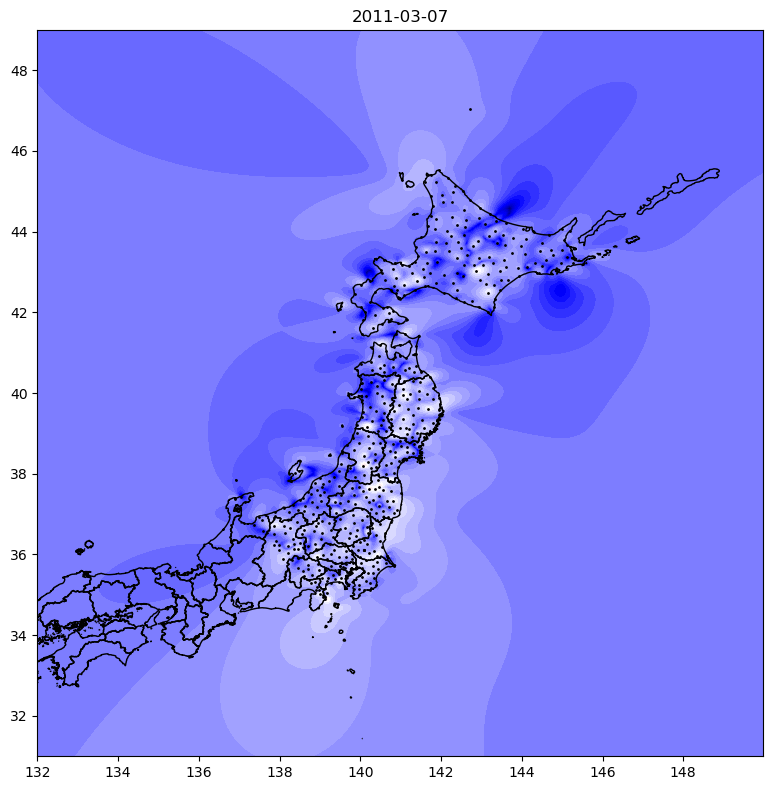

2011-03-08 00:00:00
4.6


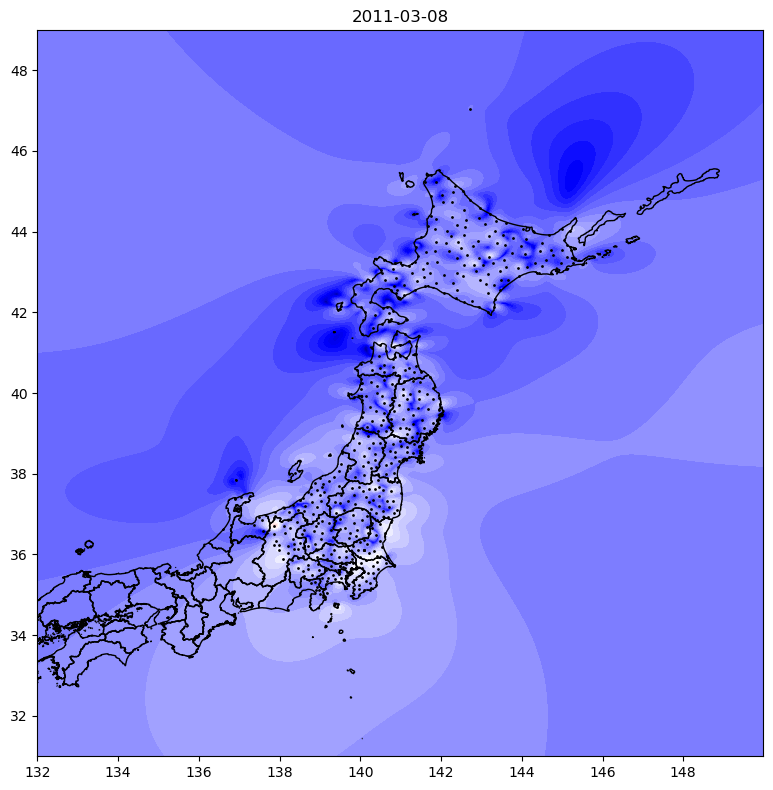

2011-03-09 00:00:00
6.4


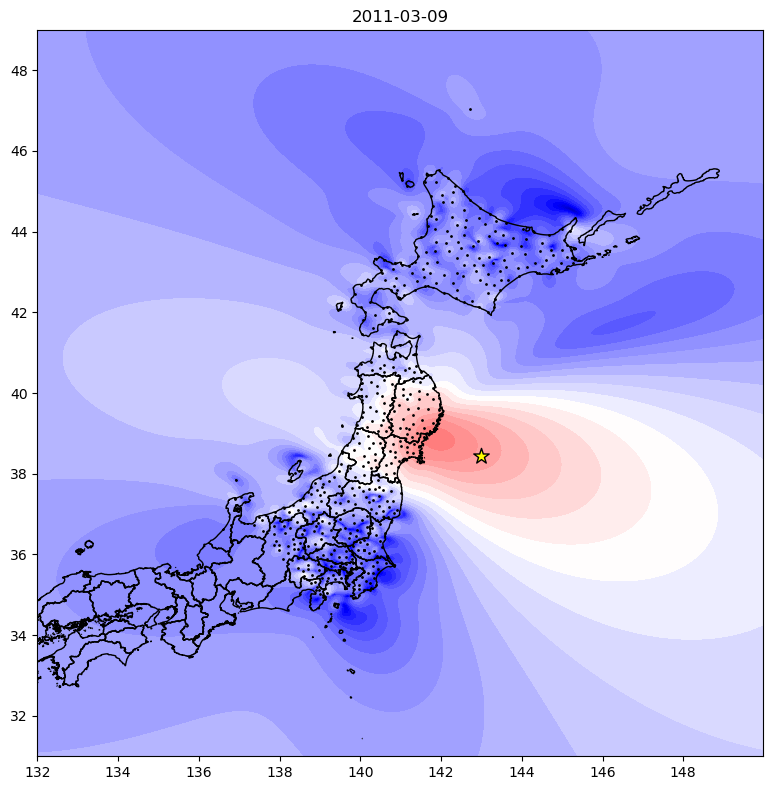

2011-03-10 00:00:00
5.3


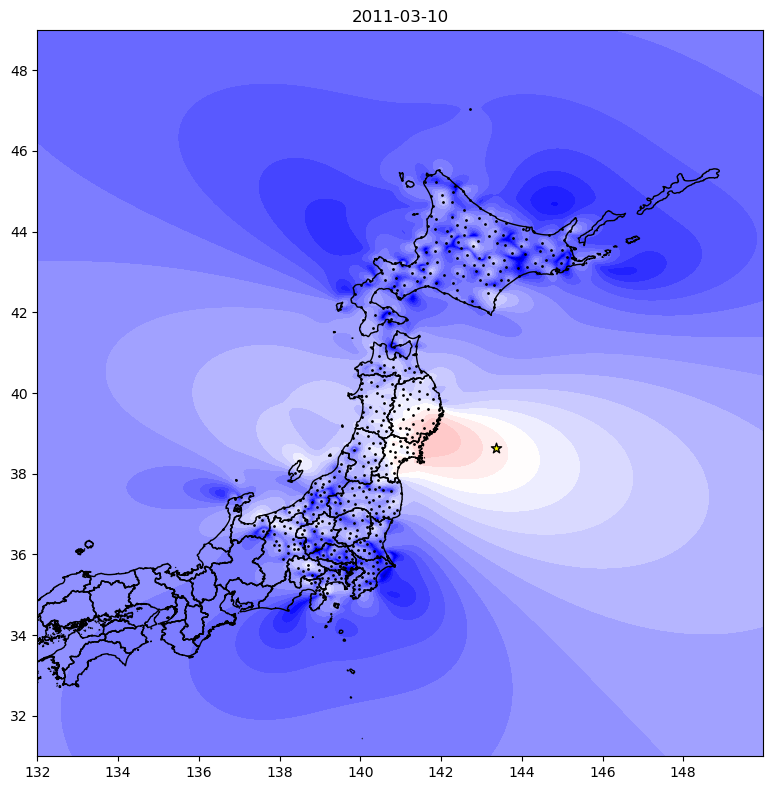

2011-03-11 00:00:00
7.1


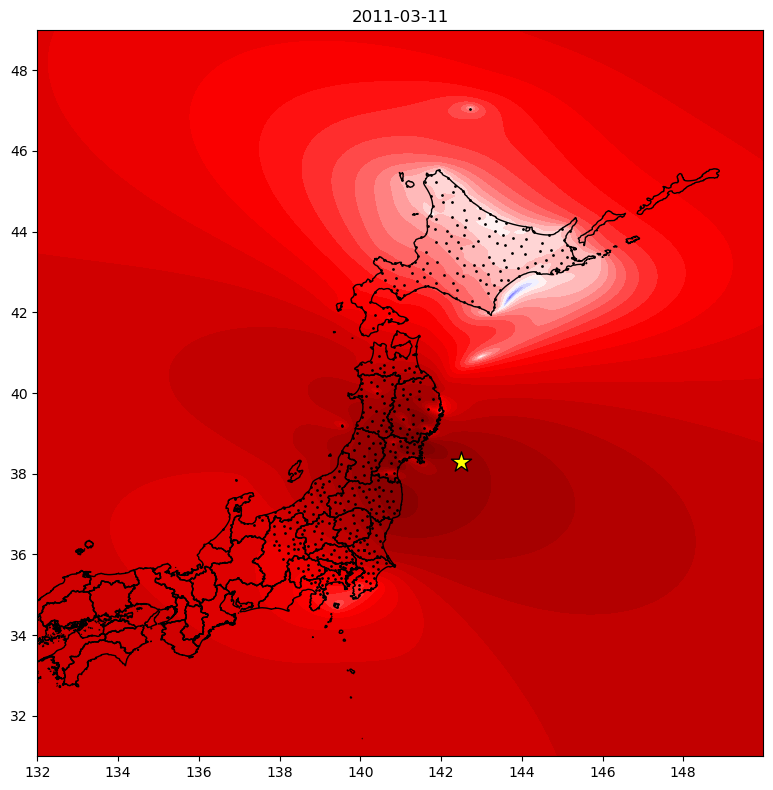

2011-03-12 00:00:00
6.1


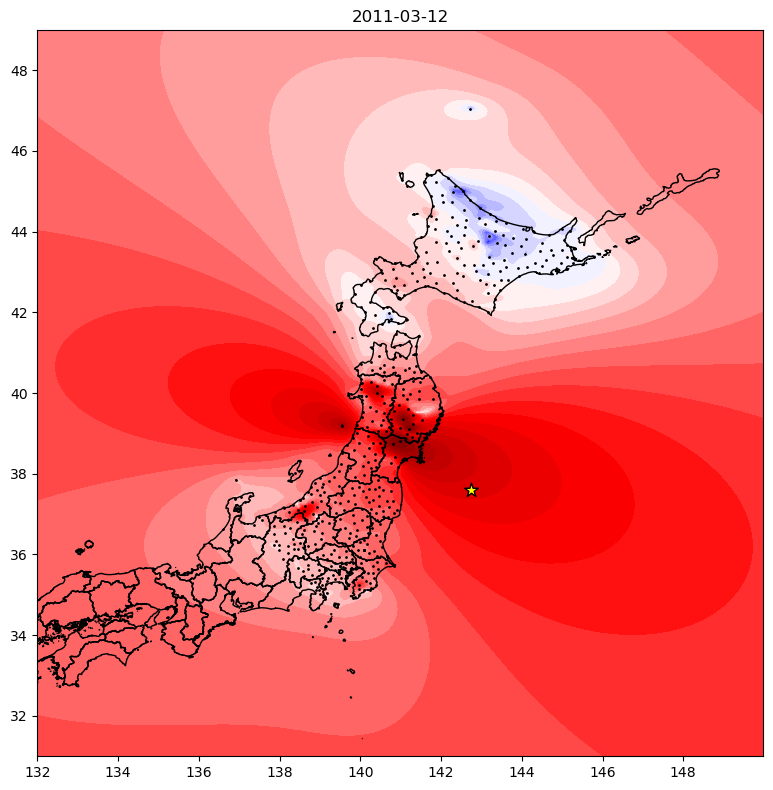

2011-03-13 00:00:00
5.9


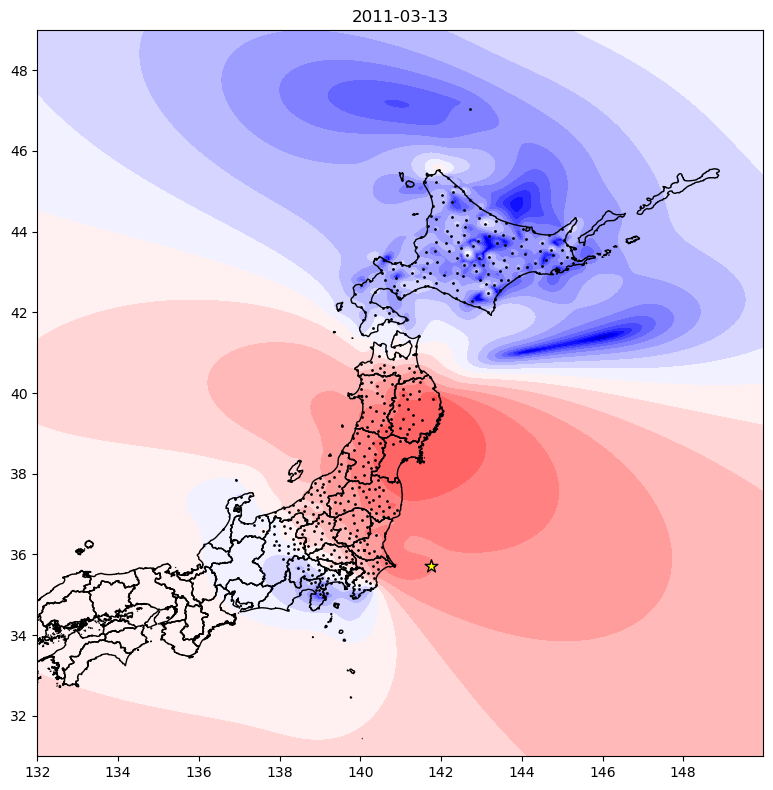

2011-03-14 00:00:00
6.0


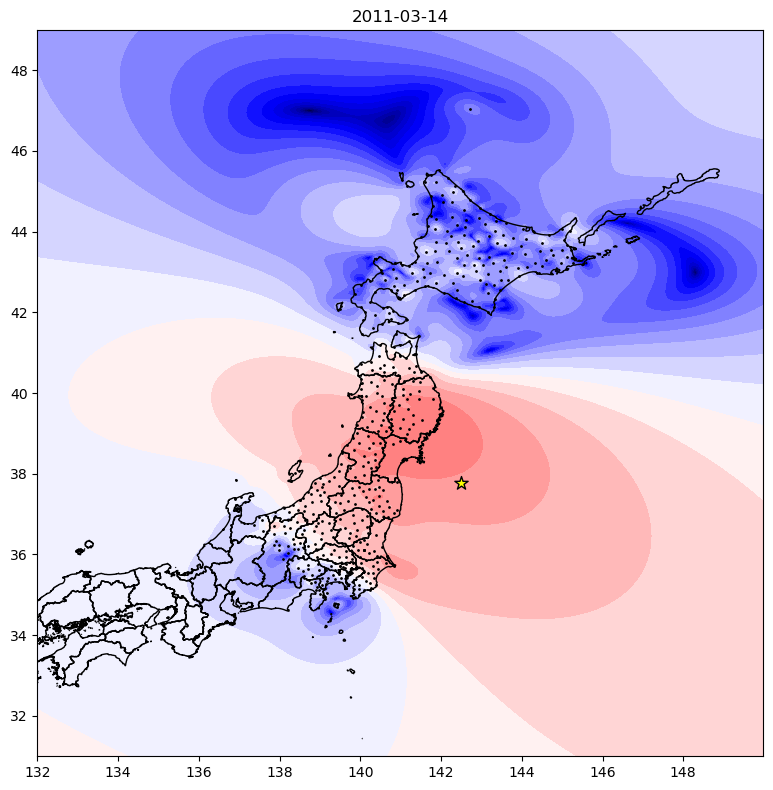

In [726]:
for time_index in range(v_maps.shape[0]):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_facecolor('cornflowerblue')
    
    date_to_plot = datetime.datetime(2011, 3, 7+time_index)
    print(date_to_plot)
    quakes = reference_catalog[reference_catalog.day==date_to_plot]
    coords = quakes[['lat','lon']].values
    #coords[:,0] -= 31
    #coords[:, 1] -= 132
    #coords /= cell_size_degs
    mags = quakes['mag'].values
    best_quake = np.nanargmax(mags)
    print(mags[best_quake])
    #plt.quiver(v_maps[time_index,:,:,0], v_maps[time_index,:,:,1])
    #plt.imshow(np.log10(np.sqrt(v_maps[time_index,:,:,0]**2+v_maps[time_index,:,:,1]**2)), cmap='seismic', vmin=-5, vmax=0.5)
    plt.contourf(np.log10(np.sqrt(v_maps[time_index,:,:,0]**2+v_maps[time_index,:,:,1]**2)), vmin=-5, vmax=0.5,levels=30, cmap='seismic', extent=(132,132+400*cell_size_degs, 31, 31+400*cell_size_degs))
    #plt.colorbar()
    jShape.plot(color='none', edgecolor='black', ax = ax, lw=1)
    plt.scatter(ref_pos[time_index][:,1], ref_pos[time_index][:,0], c='black', s=1)
    
    #plt.plot(ref_pos[time_index][hull.vertices,1], ref_pos[time_index][hull.vertices,0], 'r--', lw=2)
    #jShape.apply(lambda x: ax.annotate(text=x['ADM1_EN'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
    #plt.contour(v_maps[time_index,:,:,-1], cmap='Greys')
    plt.scatter(coords[best_quake,1], coords[best_quake,0], color='yellow', s=10**(mags[best_quake]/3), edgecolors='black', marker='*')
    #plt.imshow(np.arctan2(v_maps[time_index,:,:,0], v_maps[time_index,:,:,1]), vmin=-np.pi, vmax=np.pi, cmap='seismic')
    #plt.xlim(100, 350)
    #plt.ylim(50,250)
    
    #plt.gca().invert_yaxis()
    #plt.quiver(ref_pos[time_index][:,1], ref_pos[time_index][:,0], true_vels[time_index][:,1], true_vels[time_index][:,0], scale=1.0)
    plt.xlim(132, 132+400*cell_size_degs)
    plt.ylim(31, 31+400*cell_size_degs)
    
    plt.title(np.datetime64(date_to_plot).astype('datetime64[D]'))
    plt.gca().set_aspect(1)
    
    plt.tight_layout()
    plt.savefig(f'plots/japan_{time_index}.png')
    plt.show()
    
    

40.606167 143.841167
Candidates num.: 397
40.223333 142.3055
Candidates num.: 480
40.280167 142.421333
Candidates num.: 465
35.9375 141.427833
Candidates num.: 666
43.735833 147.329833
Candidates num.: 146
34.598333 135.035
Candidates num.: 899
43.152 146.729833
Candidates num.: 170
45.9065 152.470333
Candidates num.: 0
24.1285 121.740833
Candidates num.: 29
39.7845 143.916667
Candidates num.: 416
43.768167 148.043833
Candidates num.: 119
38.111333 135.393333
Candidates num.: 802
46.1335 151.833833
Candidates num.: 0
43.710167 147.8825
Candidates num.: 123
43.727333 148.007833
Candidates num.: 119
39.616333 143.742333
Candidates num.: 428
44.969167 150.772833
Candidates num.: 15
28.46 128.0295
Candidates num.: 99
28.063833 130.573
Candidates num.: 106
28.033167 130.380333
Candidates num.: 103
28.131167 130.370833
Candidates num.: 110
28.019 130.438833
Candidates num.: 103
44.568167 149.3595
Candidates num.: 55
44.105667 149.4905
Candidates num.: 54
44.1515 145.776833
Candidates num.: 1

39.029833 140.880667
Candidates num.: 628
45.395167 151.289167
Candidates num.: 1
27.465 128.547167
Candidates num.: 61
20.968 121.099
Candidates num.: 32
37.520833 142.2645
Candidates num.: 603
27.8325 139.9955
Candidates num.: 10
37.1365 142.341167
Candidates num.: 608
39.732 141.635333
Candidates num.: 544
41.7755 144.1515
Candidates num.: 353
38.526667 143.217167
Candidates num.: 455
36.530833 142.7
Candidates num.: 569
36.6005 142.465667
Candidates num.: 598
48.112 155.319333
Candidates num.: 0
46.995667 155.168
Candidates num.: 0
46.006833 152.192667
Candidates num.: 0
45.9915 152.073833
Candidates num.: 0
41.812333 143.620333
Candidates num.: 365
24.023 122.2175
Candidates num.: 29
24.176333 125.263333
Candidates num.: 45
33.128 138.404
Candidates num.: 717
34.786167 138.499333
Candidates num.: 823
32.869333 140.825667
Candidates num.: 445
23.276667 123.671333
Candidates num.: 31
23.438 123.633667
Candidates num.: 31
31.125833 130.3005
Candidates num.: 360
27.868667 127.858
Cand

34.844333 135.621667
Candidates num.: 893
35.165333 140.592
Candidates num.: 712
23.699167 143.217667
Candidates num.: 10
23.4635 143.847833
Candidates num.: 10
42.690833 142.006667
Candidates num.: 345
26.6235 129.594833
Candidates num.: 45
26.6715 129.6775
Candidates num.: 45
23.968833 122.602667
Candidates num.: 30
23.955 122.595833
Candidates num.: 30
47.143 147.109333
Candidates num.: 71
44.608333 145.8065
Candidates num.: 176
30.5725 131.1645
Candidates num.: 336
22.2385 146.518
Candidates num.: 0
42.008 146.862
Candidates num.: 172
36.762167 142.406333
Candidates num.: 606
25.667333 141.0295
Candidates num.: 10
40.3625 143.404833
Candidates num.: 427
24.010833 121.5145
Candidates num.: 29
31.801167 131.9745
Candidates num.: 514
29.056167 139.6625
Candidates num.: 9
38.608 139.479333
Candidates num.: 733
29.235667 128.178667
Candidates num.: 159
20.8425 121.903833
Candidates num.: 32
33.161 137.397833
Candidates num.: 779
37.707167 141.632833
Candidates num.: 652
24.374167 121.86

2000-06-03 00:00:00
35.689833 140.7465
75.24411742323556
[0.0005212  0.00522063]


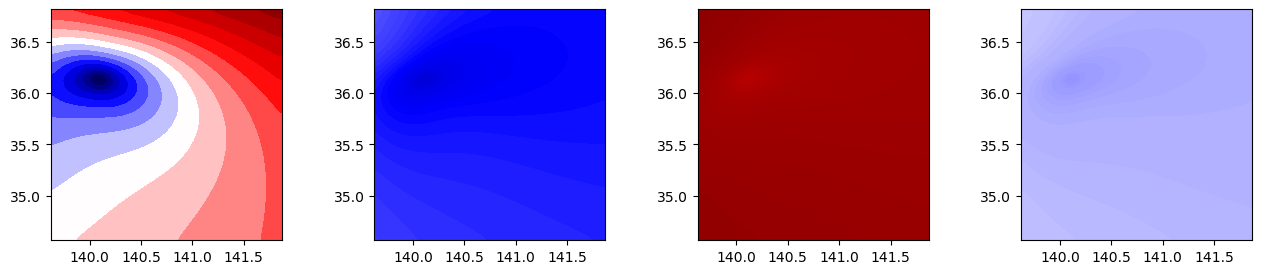

# Old

In [8]:
stats_quakes = {}
for cnt, (_, (date, lat_origin, lon_origin, mag, qid)) in enumerate(large_quakes.iterrows()):
    station_names, num_downloaded, num_existing, num_failed = ngld.download_data_year_loc_5min_rapid(date.year, lat_origin, lon_origin, 200,verbose=False)
    pp_data = ngld.postprocess_year_5min_rapid(station_names, date.year)
    if(len(station_names)>0 and (num_downloaded+num_existing) > 0):
        stats_quakes[qid] = (date, lat_origin, lon_origin, mag, qid,pp_data)
        print("#D:",num_downloaded, "#E:",num_existing, "#F:",num_failed)
        print(100*cnt/len(large_quakes))
        print("..........")

0 1 2
5.7915057915057915
..........
0 1 3
8.108108108108109
..........
0 2 6
11.196911196911197
..........
0 1 1
11.583011583011583
..........
0 2 22
14.285714285714286
..........
0 5 150
16.216216216216218
..........
0 1 59
18.146718146718147
..........
0 1 54
18.53281853281853
..........
0 3 79
21.62162162162162
..........
0 2 113
22.00772200772201
..........
0 4 10
26.254826254826256
..........
0 12 10
26.64092664092664
..........
0 2 117
27.413127413127413
..........
0 1 2
34.74903474903475
..........
0 6 5
38.22393822393823
..........
0 3 20
38.61003861003861
..........
0 1 0
39.38223938223938
..........
0 1 0
45.55984555984556
..........
0 3 0
45.945945945945944
..........
0 54 14
46.33204633204633
..........
0 1 0
47.1042471042471
..........
0 1 9
49.80694980694981
..........
0 8 2
50.19305019305019
..........
0 2 1
50.57915057915058
..........
0 77 38
50.965250965250966
..........
0 4 5
55.21235521235521
..........
0 1 1
55.98455598455598
..........
0 3 3
56.75675675675676
....

In [206]:
@njit
def longrate_seismicity(lats, lons, mags, dtimes, cell_size_degs,lat_min,lat_max,lon_min, lon_max, T_max, D_max, M_max):
    n_points_lat = math.ceil((lat_max-lat_min)/cell_size_degs)
    n_points_lon = math.ceil((lon_max-lon_min)/cell_size_degs)
    n = np.zeros((len(mags),n_points_lat, n_points_lon), dtype=np.int64)
    half_size = math.floor(D_max/cell_size_degs)
    for idx in range(len(mags)-1, -1,-1):
        total_dt = dtimes[idx]
        for jdx in range(idx-1, -1, -1):
            if(total_dt > T_max):
                break
            if(mags[jdx] <= M_max):
                center_lat_i = math.floor((lats[jdx]-lat_min)/cell_size_degs)
                center_lon_i = math.floor((lons[jdx]-lon_min)/cell_size_degs)
                for lat_i in range( max(0,center_lat_i-half_size ), min(n_points_lat, center_lat_i+half_size) ):
                    for lon_i in range( max(0,center_lon_i-half_size ), min(n_points_lon, center_lon_i+half_size) ):
                        n[idx, lat_i, lon_i] += 1
            total_dt += dtimes[jdx]
    return n    

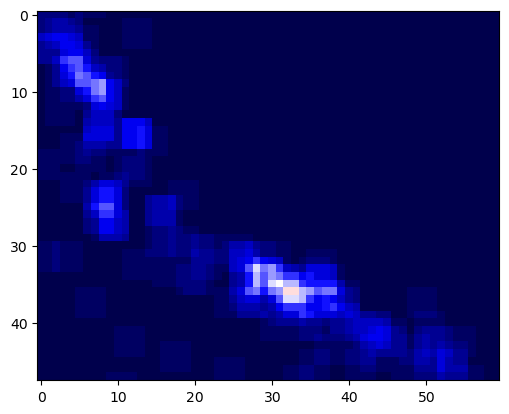

In [182]:
fig, ax = plt.subplots()
ims = []
for i,item in enumerate(s_rate[:1000]):
    im = ax.imshow(item,cmap='seismic', animated=True, vmin=0, vmax=30)
    if i == 0:
        ax.imshow(item, cmap='seismic')  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True)
ani.save("movie.mp4")
plt.show()